# Probabilistic Programming for Music Research

This notebook shows a case study of how to use Bayesian models and probabilistic programming to make inferences about musical data and corpora.
We will focus on the python library [PyMC](https://www.pymc.io/welcome.html), but also show some examples in [pyro](http://pyro.ai/) and [numpyro](https://num.pyro.ai/en/stable/).

The case study deals with a toy example: modeling the sizes of melodic intervals in Bach chorales.
You will see how to express different assumptions about how these intervals work in probabilistic models,
how to apply these models to a dataset to make inferences,
and how to compare and evaluate the different models.

In [1]:
# data
import pandas as pd
import numpy as np

# PyMC (good for MCMC inference)
import pymc as pm
import pytensor as ptn

# pyro (uses torch, good for variational inference)
import pyro
import pyro.distributions as dist
import torch
import tqdm # progress bar

# numpyro (uses jax, good for MCMC and variational inference, but docs are a bit messy)
import numpyro
import numpyro.distributions as ndist
from numpyro.ops.indexing import Vindex
import jax
import jax.numpy as jnp

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import arviz as az

In [2]:
# setup
%config InlineBackend.figure_format = "retina"
rng = np.random.default_rng(14842)

# for numpyro
numpyro.set_host_device_count(2)
rng_key = jax.random.PRNGKey(14842)
# useful for debugging:
# jax.config.update("jax_debug_nans", True)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Data

Here we just load the dataset that we will work with.
It contains a list so-called "bigrams" - pairs of sequential notes - from each voice of the first 100 chorales in the 371 Bach chorales collection.
Thus, for each bigram we know the pitch of the first note (in MIDI as well as tpc (= line-of-fifths position) + octave),
the pitch of the second note, the voice (staff) and piece in which it appears,
as well as some derived information such as the interval in semitones and the absolute size of the interval in semitones.

In [3]:
dists = pd.read_csv("bigrams.tsv", sep="\t", index_col=["piece", "staff", "bigram_id"])
dists

n0_tpc  n0_octave  n1_tpc  n1_octave  n0_midi  \
piece   staff bigram_id                                                  
chor001 1     0               1          4       1          4       67   
              1               1          4       2          5       67   
              2               2          5       5          4       74   
              3               5          4       3          4       71   
              4               3          4       1          4       69   
...                         ...        ...     ...        ...      ...   
chor100 4     56              2          3      -3          3       50   
              57             -3          3       2          3       51   
              58              2          3       0          3       50   
              59              0          3       2          3       48   
              60              2          3       1          2       50   

                         int_fifths  int_octaves  int_semitones  \
piece   staff bigram_id                                           
chor001 1     0                   0            0              0   
              1                   1            0              7   
              2                   3           -2             -3   
              3                  -2            1             -2   
              4                  -2            1             -2   
...                             ...          ...            ...   
chor100 4     56                 -5            3              1   
              57                  5           -3             -1   
              58                 -2            1             -2   
              59                  2           -1              2   
              60                 -1            0             -7   

                         dist_semitones  
piece   staff bigram_id                  
chor001 1     0                       0  
              1                       7  
              2                       3  
              3                       2  
              4                       2  
...                                 ...  
chor100 4     56                      1  
              57                      1  
              58                      2  
              59                      2  
              60                      7  

[22018 rows x 9 columns]

Let's have a look at the distribution of the (directed) intervals in each voice.
We can see that they are usually centered around 0 (unison) and roughly symmetric.
Smaller intervals are more frequent than larger intervals.
The distribution looks similar in the different voices, but not exactly the same.

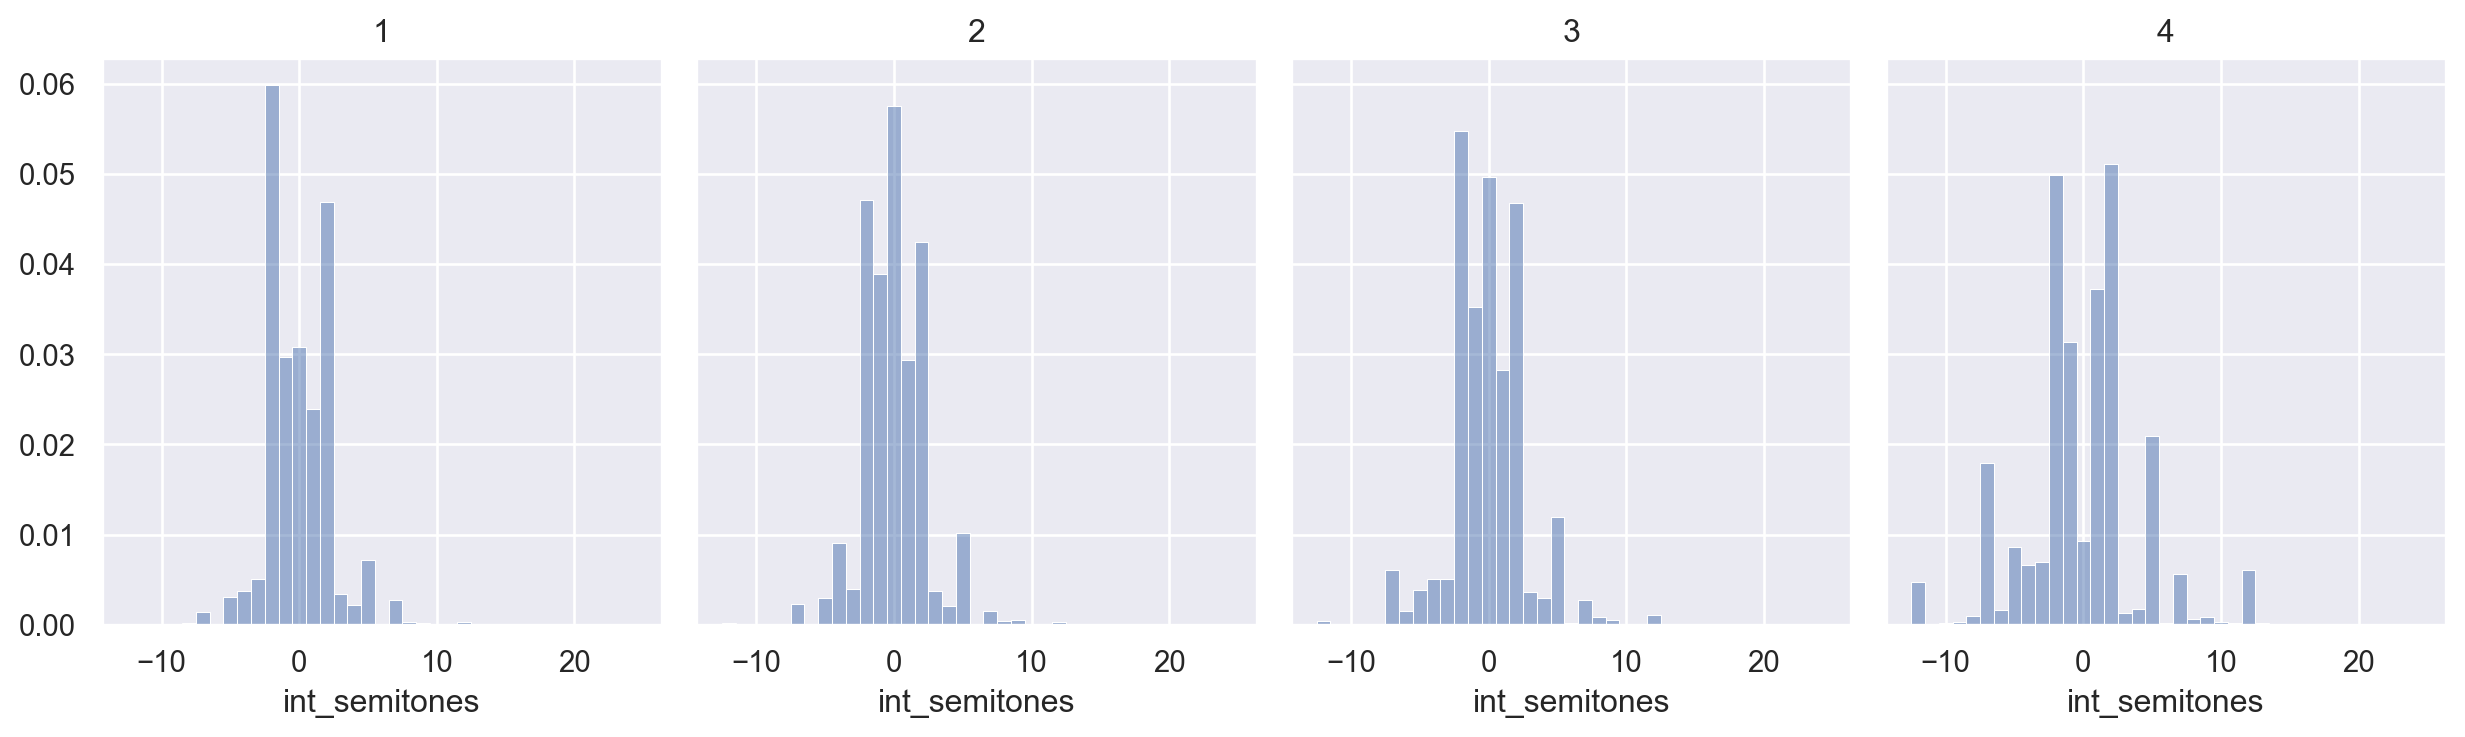

In [4]:
(
    so.Plot(dists, x="int_semitones")
        .facet("staff")
        .add(so.Bars(alpha=0.5), so.Hist("probability", discrete=True))
        #.add(so.Line(), so.KDE())
        .layout(size=(13,4))
)

Here is the same plot for the absolute distances.

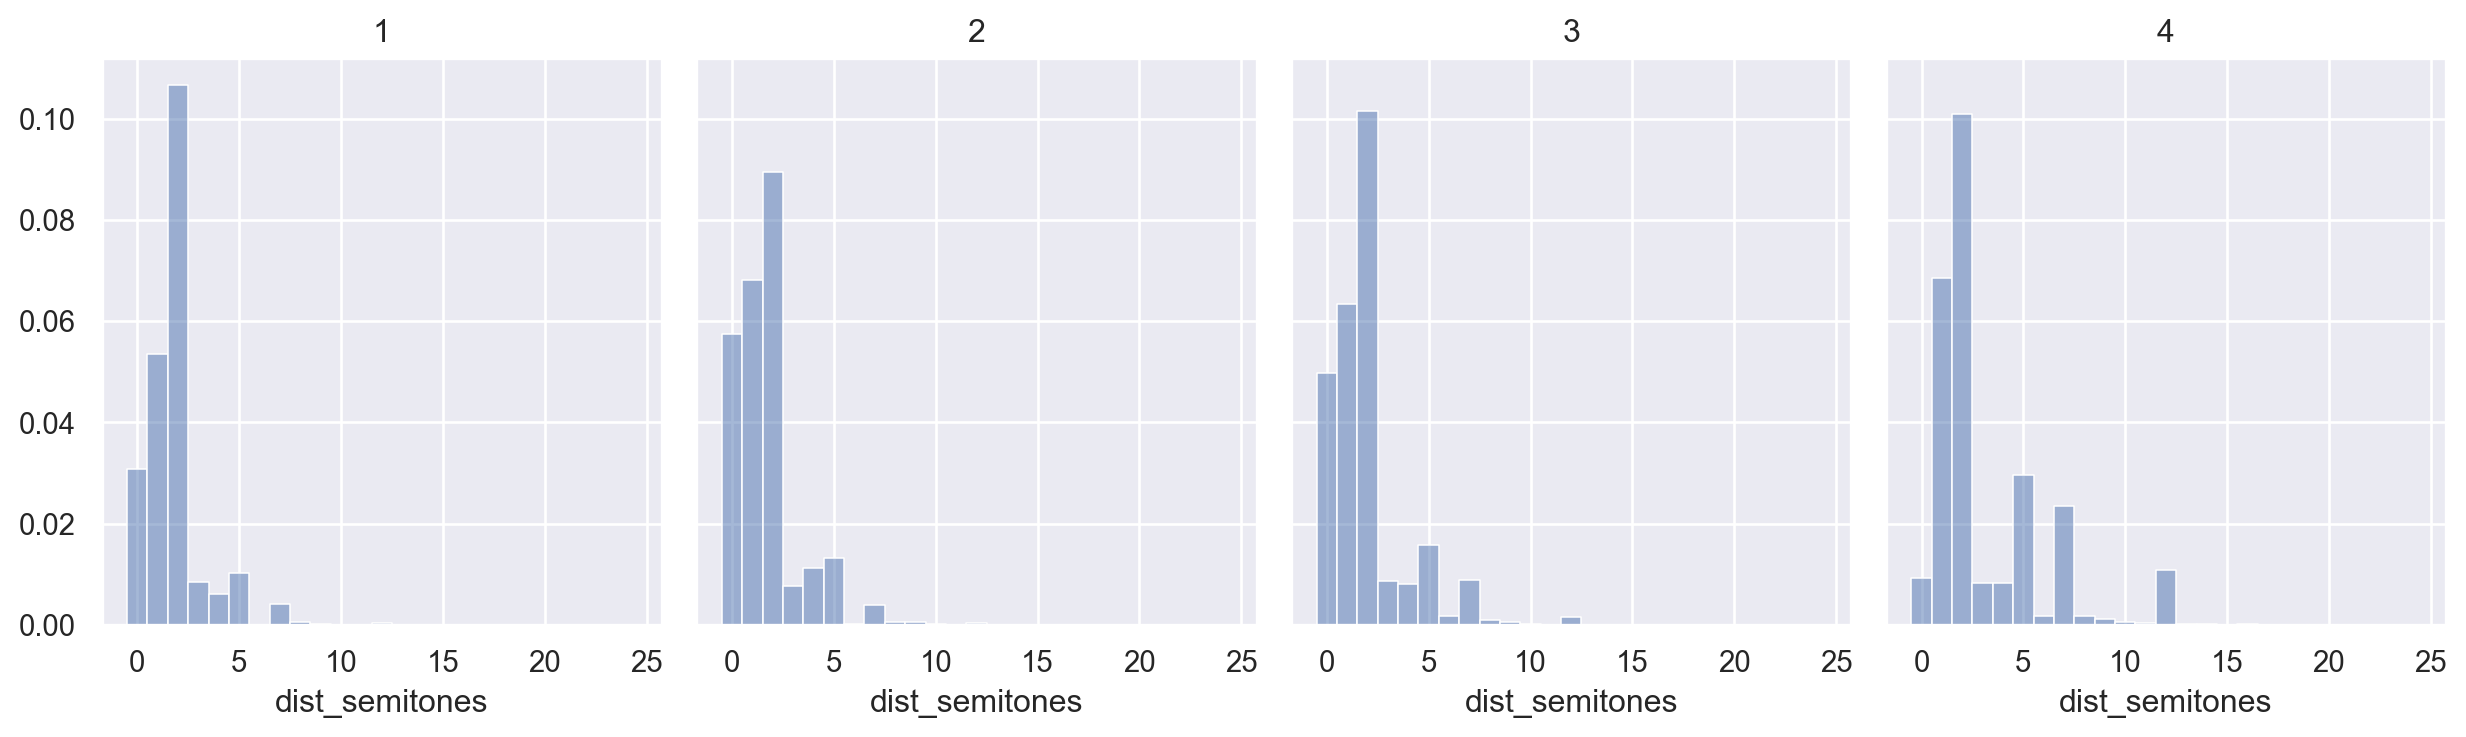

In [5]:
(
    so.Plot(dists, x="dist_semitones")
        .facet("staff")
        .add(so.Bars(alpha=0.5), so.Hist("probability", discrete=True))
        #.add(so.Line(), so.KDE())
        .layout(size=(13,4))
)

Let's now extract some of this data that we will use for modelling:
- the observed absolute intervals or "distances"; this is what we want to understand
- the staff in which a bigram appears
- the pitch (MIDI) of the first note in each bigram

The latter two might have an influence on the intervals that we observe,
and this relationship is what we are going to model and make inferences about.

In [6]:
observations = np.array(dists["dist_semitones"].to_numpy())
observations

array([0, 7, 3, ..., 2, 2, 7])

In [7]:
staff = dists.index.get_level_values("staff").to_numpy()-1
staff

array([0, 0, 0, ..., 3, 3, 3])

In [8]:
p0 = dists["n0_midi"].to_numpy()
p0

array([67, 67, 74, ..., 50, 48, 50])

In [9]:
# a helper function for later
def estimate_beta(samples):
    mean = samples.mean(dim=["chain", "draw"]).to_numpy()
    var = samples.var(dim=["chain", "draw"]).to_numpy()
    common = (mean * (1-mean) / var) - 1
    alpha = common * mean
    beta = common * (1-mean)
    return alpha, beta

# Model 1: one global spread parameter

Our first model is very simple: we just assume the observed intervals to be random.
But "random" doesn't mean "completely arbitrary",
we still assume that they follow a certain distribution.
If we look at the shape of the data in the plots above, we can see that
very large intervals are possible but small steps or unisons are most likely.
Thus, we pick a [geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution),
which works as follows:
You flip a coin (with a certain probability $\theta$) until it shows *heads* for the first time.
You then count the number of trials.
This is a bit like taking a number of steps (here: steps away from the previous note),
but at each step you flip a coin to determine if you want to keep walking or stay where you are.
So it's not an entirely unreasonable model for musical intervals,
we just try to decide how far we want to go away from the previous note.

If we write this (very simplistic) view on how melodic intervals work
and try to express it as a generative model, it looks something like this:
- Choose a $\theta$ between 0 and 1
- For each $i$ between $0$ and $N$:
  - Choose $x_i$ from a geometric distribution with parameter $\theta$.

Since our model needs a prior distribution for $\theta$,
we will choose a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).
The reason for this is that the beta distribution is a so-called "conjugate prior" to the geometric distribution.
That means: if the prior $p(\theta)$ is beta-distributed and it is used in a geometric distribution ($p(x|\theta)$),
then the posterior $p(\theta|x)$ will again be a beta distribution!
In particular, we choose the distribution $Beta(0.5, 0.5)$, which is the so-called [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior), an uninformative prior.
(In our case, we have so much data that the choice of the prior doesn't really make a big difference for $\theta$,
so we could also pick $Beta(1,1)$, which is actually a uniform distribution between 0 and 1).

If we now write down our model, it looks like this:
- Choose $\theta \sim Beta(0.5, 0.5)$
- For each $0 \leq i \leq N$:
  - Choose $x_i \sim Geometric_0(\theta)$.
 
And that is exactly how we define the model in PyMC!
The main differences are:
- We give a name to each random variable *twice*:
  in every distribution, so that PyMC can keep track of the variable during sampling (e.g. `pm.Beta("theta_global", ...)`);
  and as a python variable in our program so that we can use the value later on in the model (e.g. `theta = ...`),
- We already say that the $x_i$ are *observed* and provide the corresponding values (`observed=...`).
- We tell PyMC to draw 10.000 samples from the posterior distribution $p(\theta | \vec{x})$ using `pm.sample()`.

In [10]:
with pm.Model() as model_simple:
    theta = pm.Beta("theta_global", 0.5, 0.5)
    obs = pm.Geometric("obs", p=theta, observed=observations+1) # +1 for geometric distribution (starts at 1, not 0)

    idata_simple = pm.sample(5_000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_global]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


The returned samples are stored in an "inference data" object,
together with some extra informtation (e.g. the numer of chains and samples, infos about the sampling process, etc.).
It is rendered in a nice way in the notebook.
If you look inside the "posterior" branch, you can find the sampled variables there (here just `"theta_global"`).

In [11]:
idata_simple

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

We can have a look at the samples that were drawn using `arviz` plotting functions.
The left plot shows two lines because we have used two MCMC chains.
The right plot shows which values were drawn over time, so we can see if there are systematic differences
between early and late samples (that would be bad!).

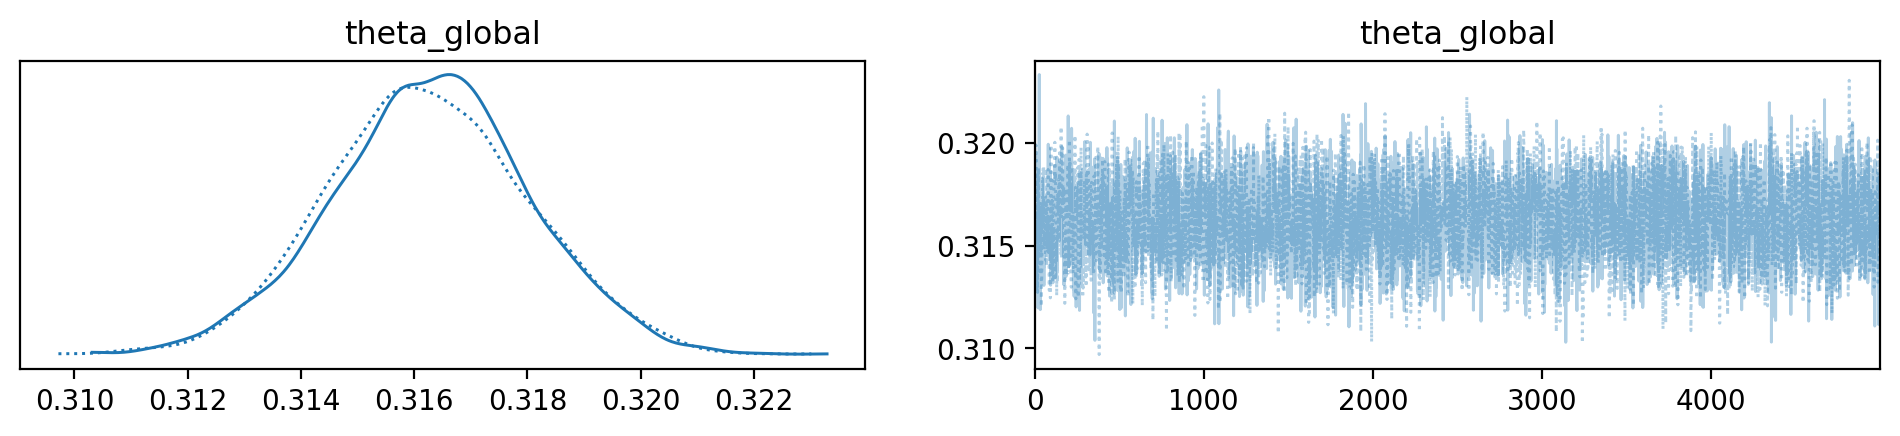

In [12]:
az.plot_trace(idata_simple);

This is another view of the posterior samples with some extra information.
As you can see, the "true" value of `theta` is probably close to 0.316 or 0.317,
but there is always a bit of uncertainty left (although it's not very large here).
We can obtain the precise expected value by just taking the mean of the samples,
but keep in mind that this is still only an estimate!

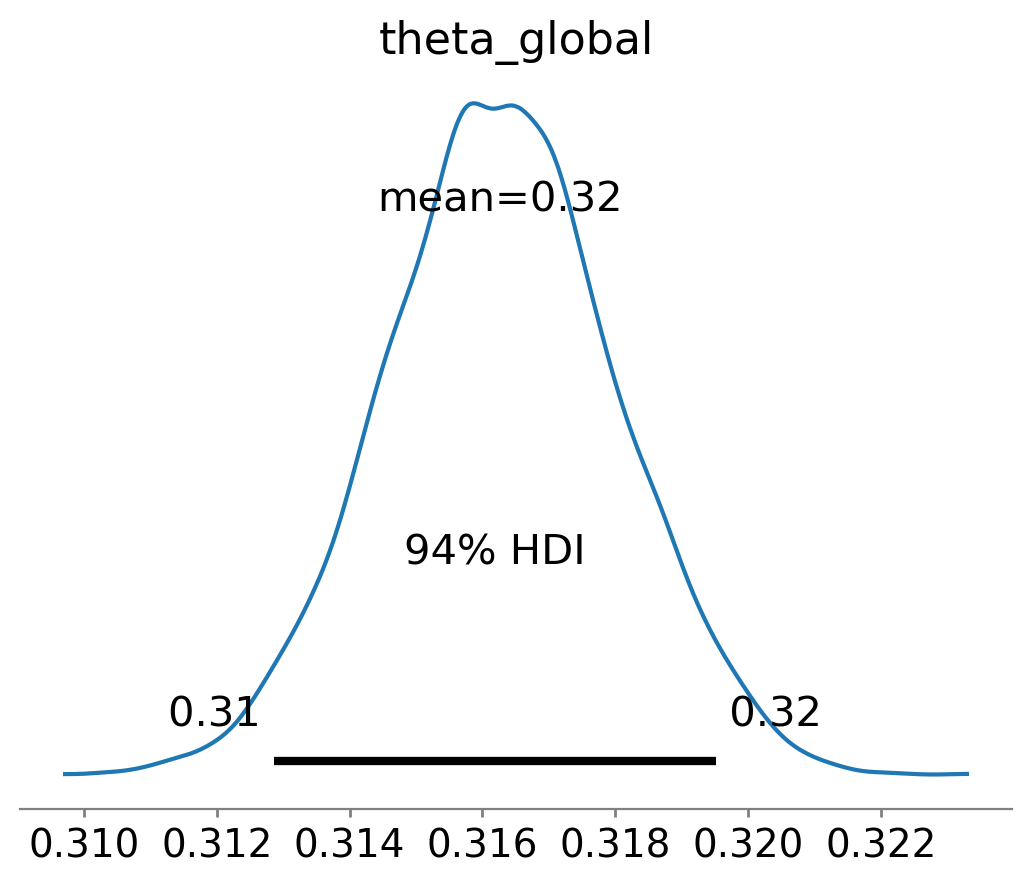

In [13]:
az.plot_posterior(idata_simple);

In [14]:
# expected value:
idata_simple.posterior["theta_global"].to_numpy().mean()

0.31626165353925856

# Model 2: one parameter per voice

The first model makes a lot of unrealistic assumptions about how interval sizes are determined.
Basically, the size of an interval is completely independent from where it occurs, in which voice,
or what happens around it, and all intervals follow the same distribution.

Let's try to make the model a bit less unrealistic.
What if the voice actually makes a difference?
We can try that out by chaning the model above a little bit
and generate one $\theta$ for each voice:
- For each voice $v$:
  - Choose $\theta_v \sim Beta(0.5, 0.5)$
- For each $0 \leq i \leq N$:
  - Choose $x_i \sim Geometric_0(\theta_{v_i}) = p(x_i | v_i)$
 
We can tell PyMC to draw 4 $\theta$ instead of one by adding `shape=4` to `pm.Beta()`.
Then, `pm.Geometric()` doesn't use a fixed `theta`,
instead `theta[staff_]` gives us an array with the right theta for each observation.

Another change to the first model is more technical:
we add the relevant data (`obs` and `staff`) to the model as `MutabaleData`.
This will come in handy later as it allows us to change the data without having to redefine the model.

In [15]:
with pm.Model() as model_voice:
    staff_ = pm.MutableData("data_staff", staff)
    obs_ = pm.MutableData("data_obs", observations+1)
    theta = pm.Beta("theta_voice", 0.5, 0.5, shape=4)
    obs = pm.Geometric("obs", p=theta[staff_], observed=obs_) # +1 for geometric distribution (starts at 1, not 0)

    idata_voice = pm.sample(5_000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_voice]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 52 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


We now obtain posterior samples for each theta (0-3 = soprano - bass).
The trace plot doesn't label them nicely, but the order of colors is:
- blue = soprano
- orange = alto
- tenor = green
- red = bass

So the bass has a low $\theta$, which corresponds to larger expected intervals,
while the alto has a high $\theta$, corresponding to smaller intervals!

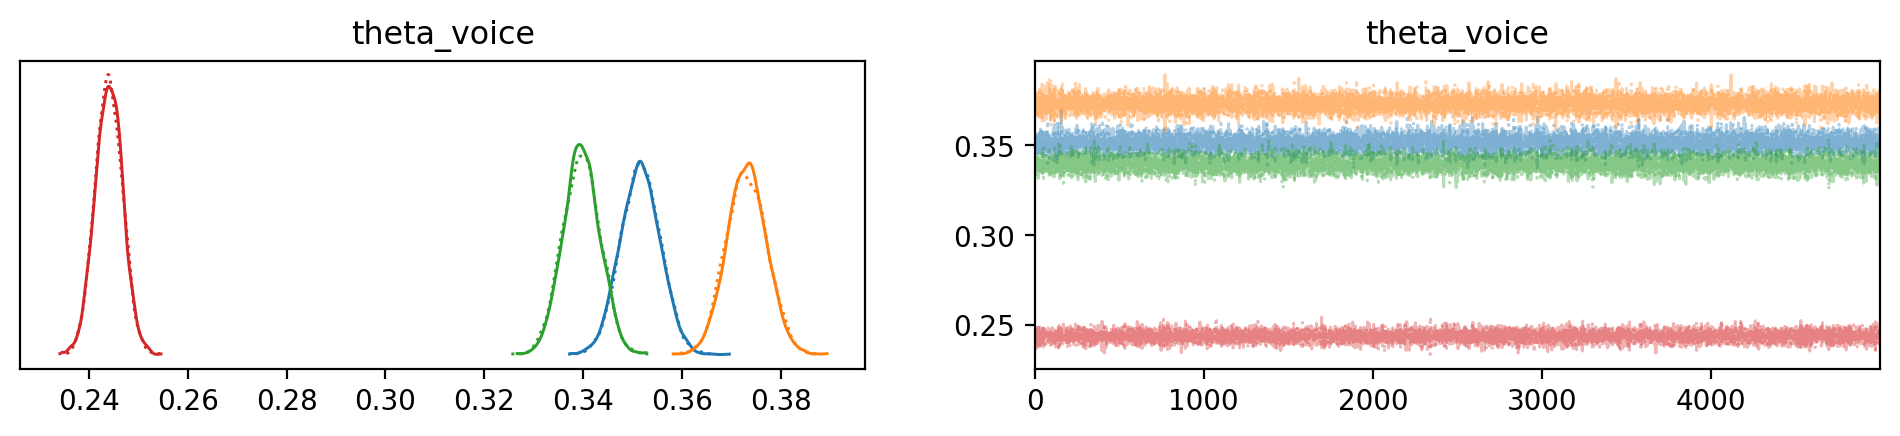

In [16]:
az.plot_trace(idata_voice);

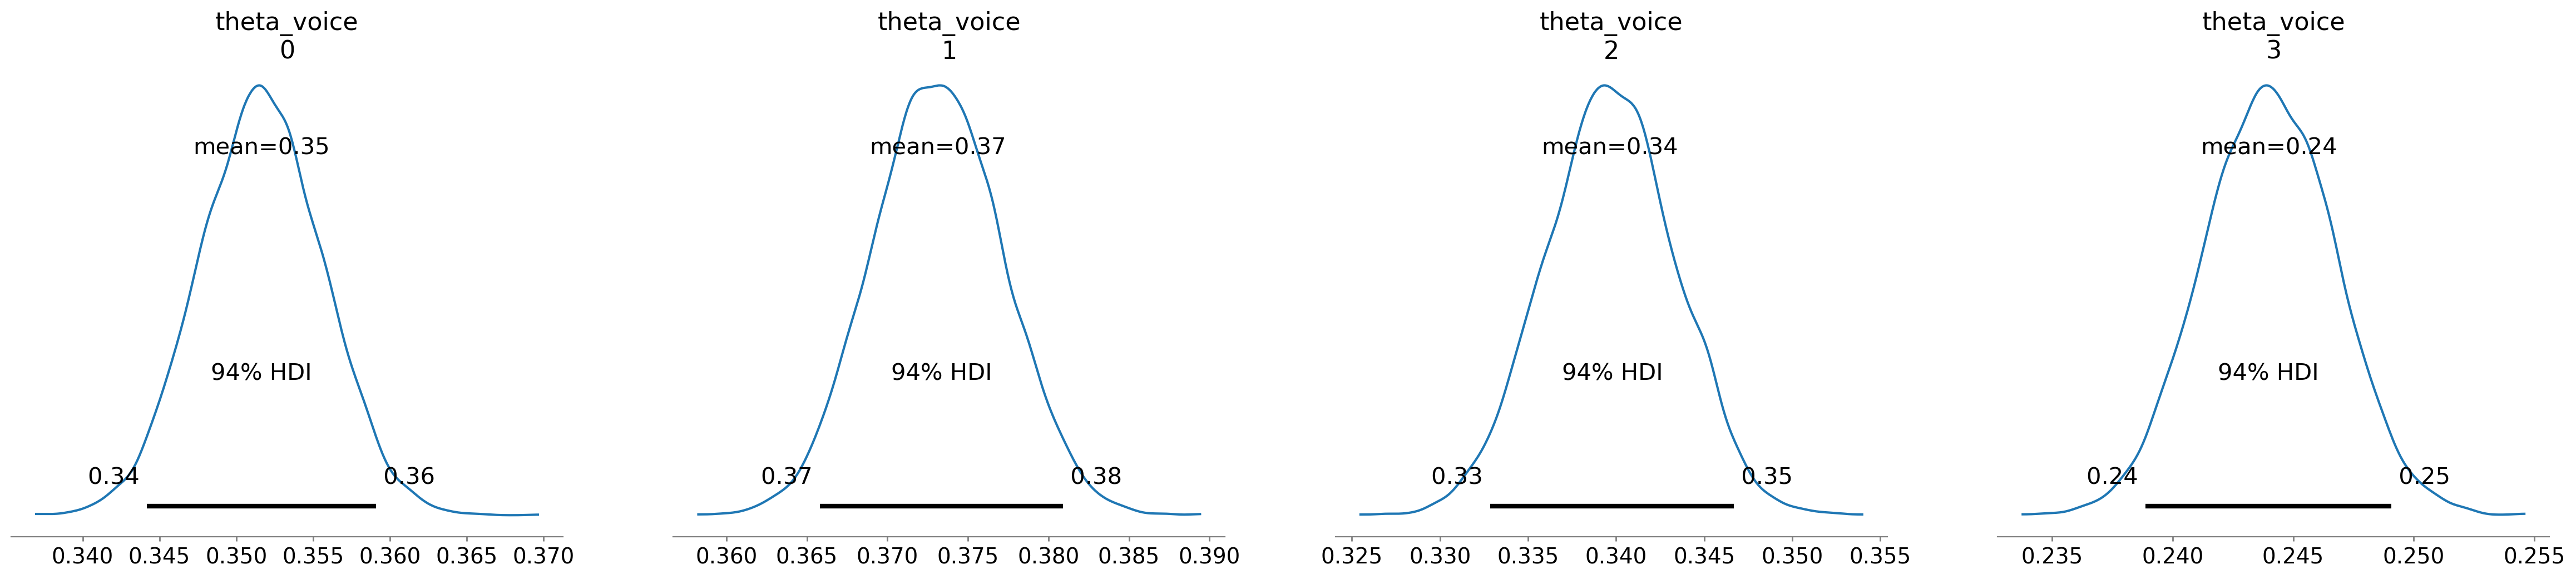

In [17]:
az.plot_posterior(idata_voice);

# Model 3: depend on register

So what if the size of the intervals doesn't actually depend on the voice but on the register that they appear in?
After all, vertical intervals tend to be larger in lower registers and smaller in higher registers too!
Let's first have a look at the data, to see, if that could make sense:

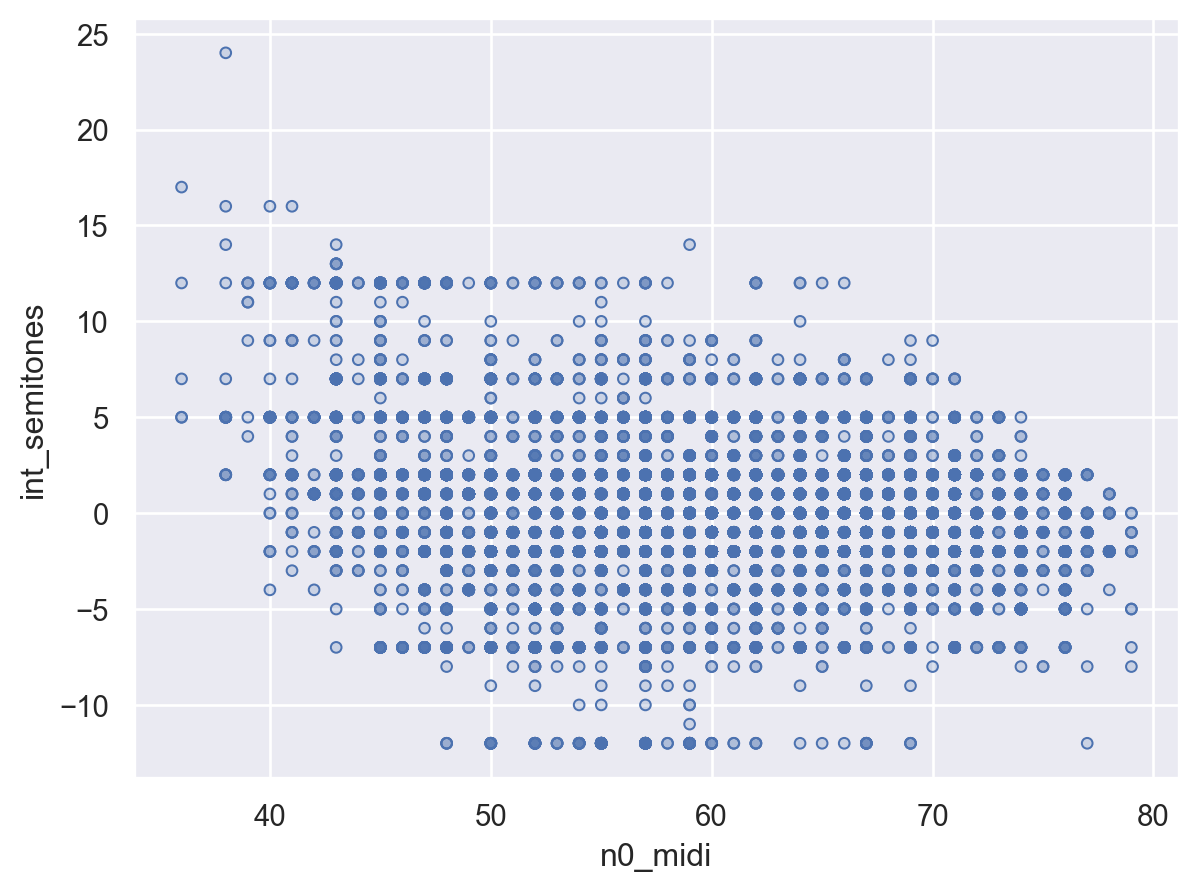

In [18]:
(
    so.Plot(dists, x="n0_midi", y="int_semitones").add(so.Dots())
)

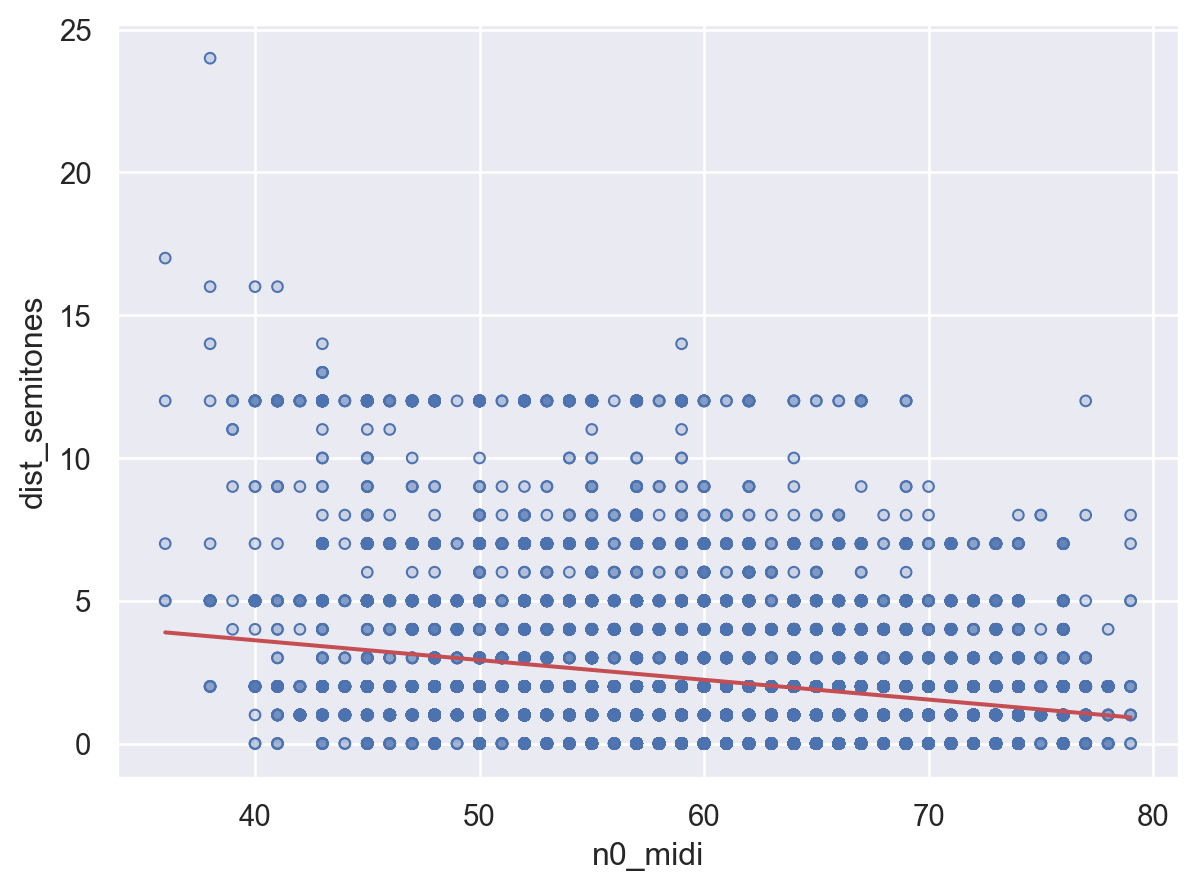

In [19]:
(
    so.Plot(dists, x="n0_midi", y="dist_semitones").add(so.Dots()).add(so.Line(color="r"), so.PolyFit(1))
)

In the second blot we see a slight tendency to get smaller intervals if the first note of the bigram is higher.
The added regression line seems to support that.
But is a linear regression really the right tool here?

Let's instead try to modify our model.
We keep the geometric distribution, but we make theta dependent on the pitch of the previous note ($p_0$).
In particular, we use a linear dependency between the pitch and the output:

$f(p_0) = a p_0 + b$

Then, we wrap the resulting value into a sigmoid function,
which is a curve with an S-shape that maps small values close to 0 and large value close to 1:

$\theta(p_0) = sigmoid(a p_0 + b) = \dfrac{1}{1+exp(-(a p_0 + b))}$

So the parameters that we have to infer are the slope $a$ and the intercept $b$.
Both of them could be any real number, but they are probably somewhere around zero rather than completely far off,
so we give them a normal prior distribution with a relatively large standard deviation.

In [20]:
with pm.Model() as model_register:
    p0_ = pm.MutableData("data_p0", p0)
    obs_ = pm.MutableData("data_obs", observations+1)
    a = pm.Normal("a", 0, 10)
    b = pm.Normal("b", 0, 10)
    theta = pm.math.sigmoid(p0_*a + b)
    obs = pm.Geometric("obs", p=theta, observed=obs_)

    idata_register = pm.sample(5_000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 467 seconds.


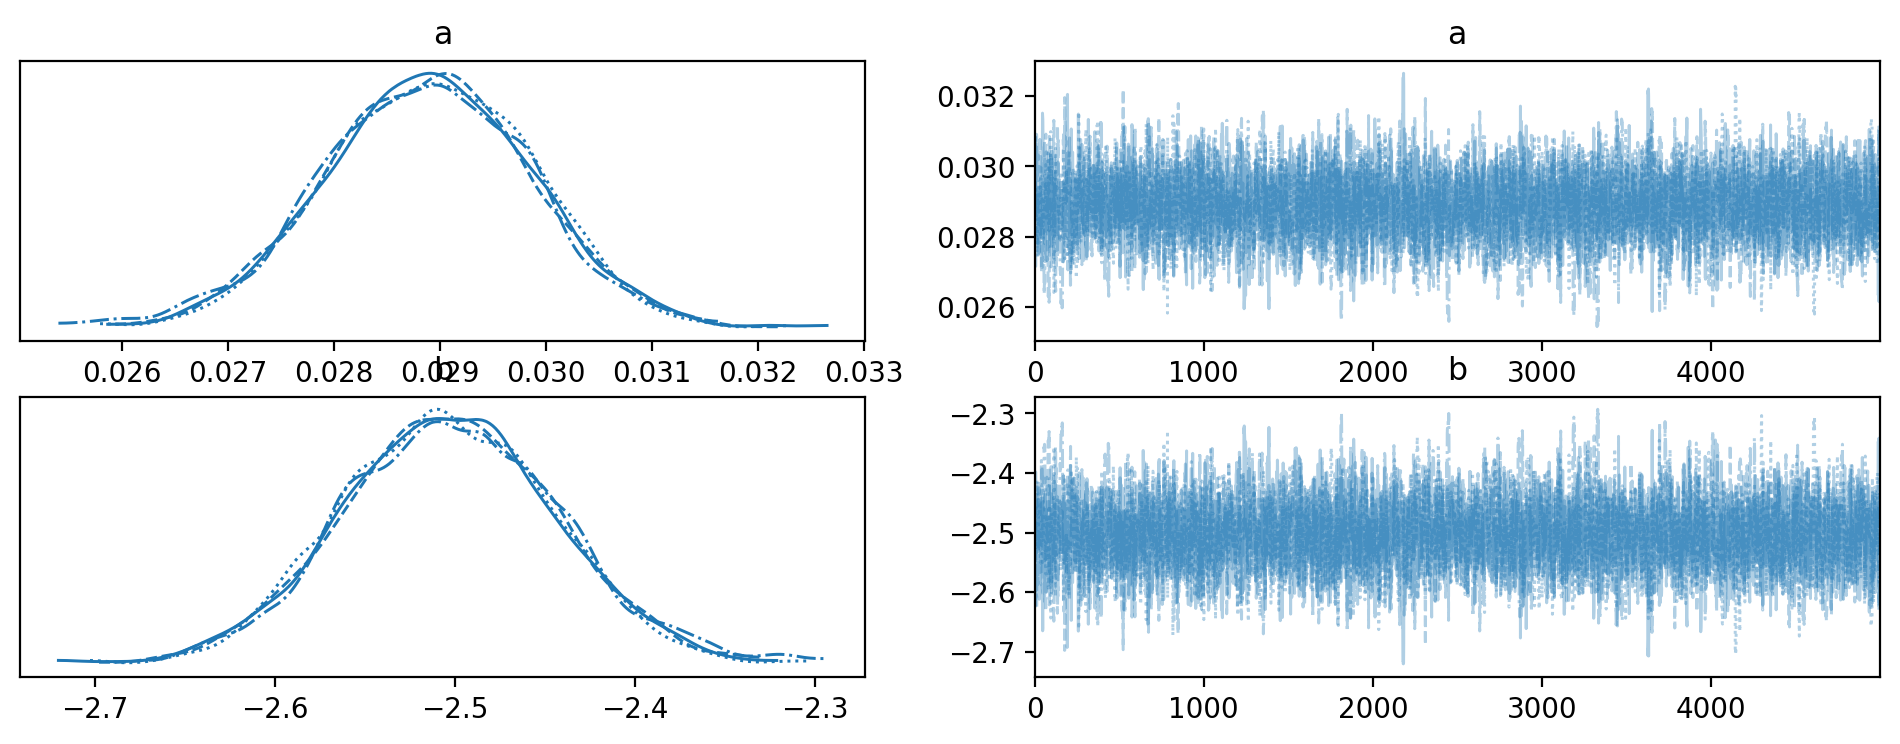

In [21]:
az.plot_trace(idata_register);

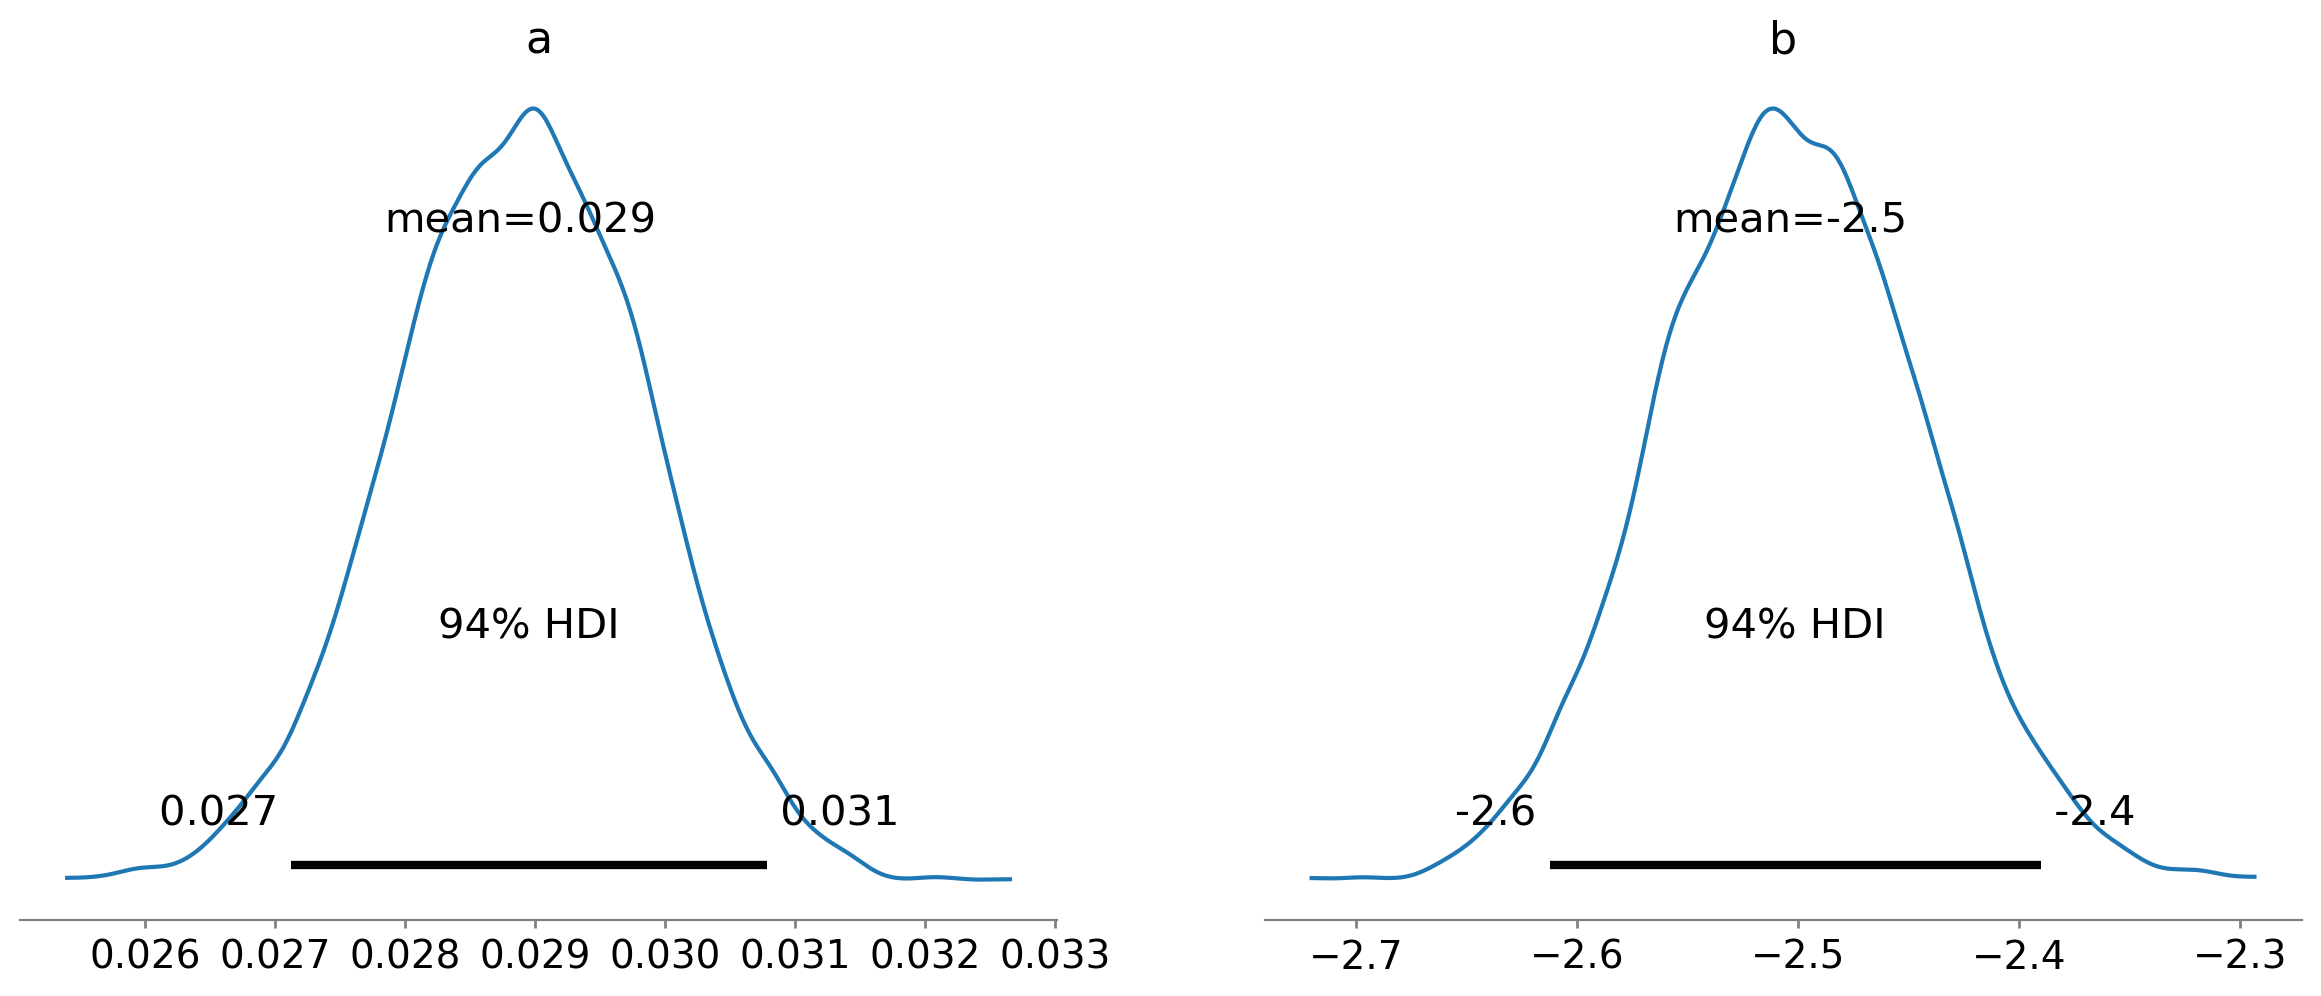

In [22]:
az.plot_posterior(idata_register);

The posterior samples show us that the slop of the function is positive, so $\theta$ becomes larger for higher registers.
But what exactly does that mean?
Let's first look at the resulting sigmoid shape of $\theta$ by using the expected values of $a$ and $b$:

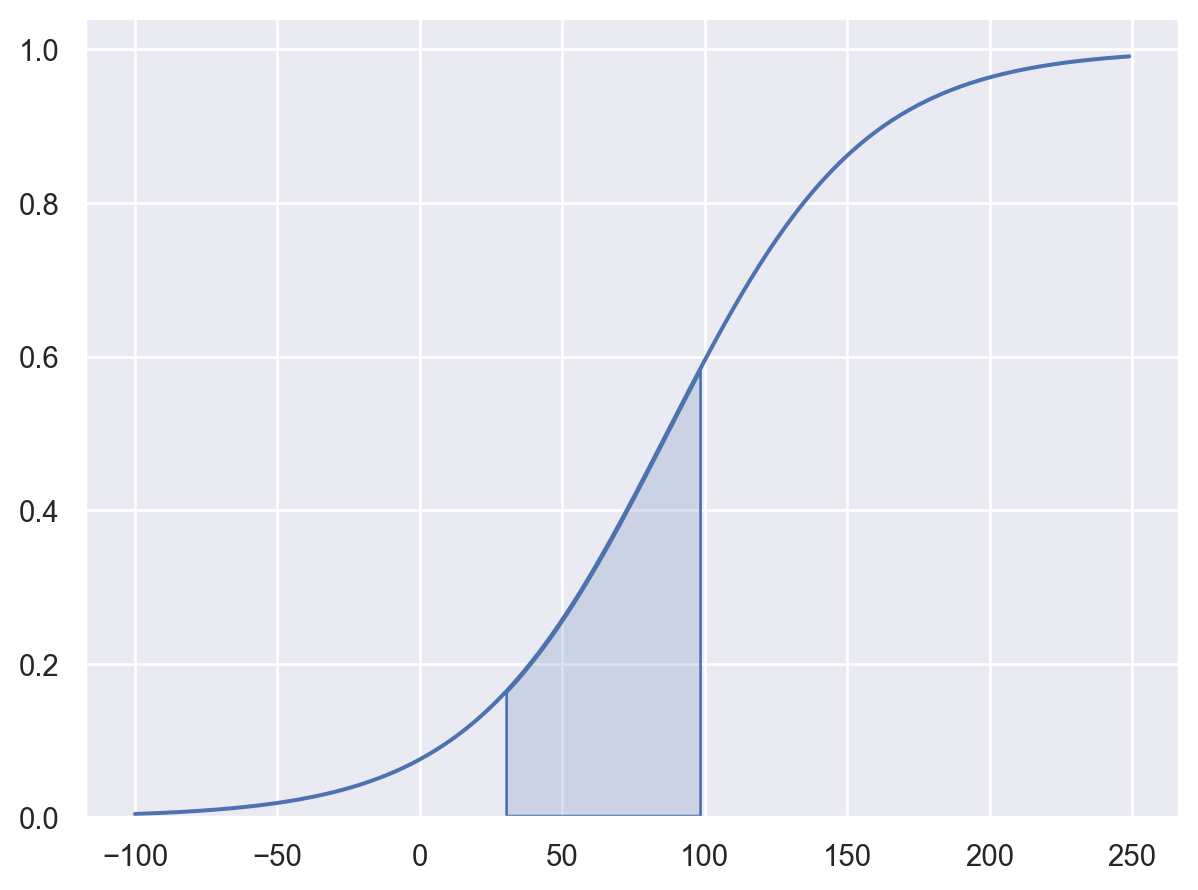

In [23]:
def plot_sigmoid(a, b):
    x = np.arange(-100,250)
    # y = 1 / (1 + np.exp(-(a*x + b)))
    y = pm.math.sigmoid(x*a + b).eval()
    return so.Plot(x=x, y=y).add(so.Line()).add(so.Area(), x=x[130:200], y=y[130:200])

plot_sigmoid(idata_register.posterior["a"].mean().item(), idata_register.posterior["b"].mean().item())

So $\theta$ changes quite a bit from less than 0.2 for low pitches to almost 0.6 for the highest.
But we can't really see the uncertainty here, and it's still a bit difficult to imagine what that means for the intervals.
So let's look at the *expected interval size* in different registers,
and actually use the posterior samples to get an idea of how much this could vary:

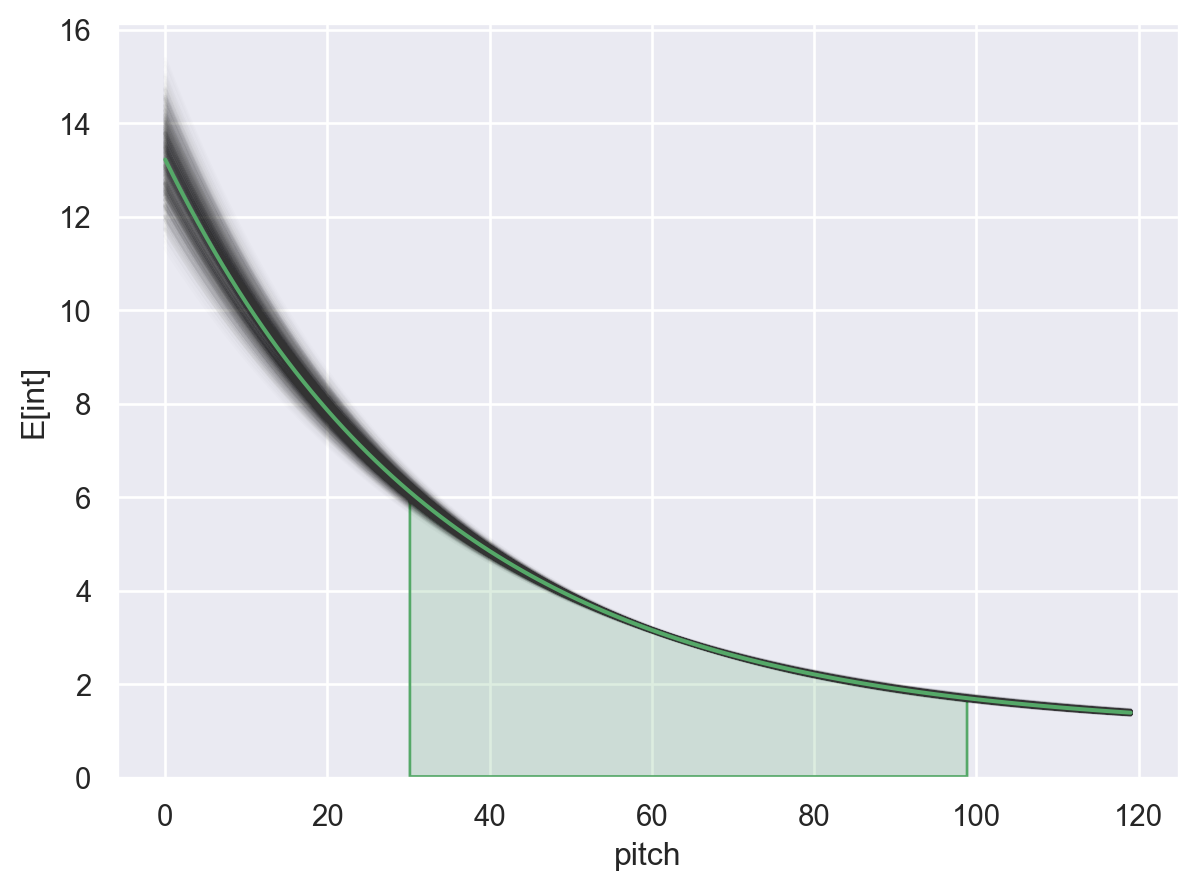

In [24]:
def plot_sigmoids(a, b):
    # select some samples
    ny = 1_000
    indices = rng.choice(np.arange(a.size), ny, replace=False)

    # compute the sigmoids for the selected samples
    x = np.arange(0,120)
    y = (1 + np.exp(-(np.atleast_2d(a[indices]).T * np.atleast_2d(x) + np.atleast_2d(b[indices]).T)))

    # create a dataframe that holds the sample sigmoids, this makes it easier to plot with seaborn
    data = pd.DataFrame({
        "pitch": np.tile(x, ny),
        "E[int]": y.flatten(),
        "group": np.concatenate([np.full(x.size, iy) for iy in range(ny)])
    })
    
    # compute the sigmoid for the sample mean over all samples (same as previous plot)
    amean = a.mean()
    bmean = b.mean()
    ymean = (1 + np.exp(-(amean*x + bmean)))

    # create the plot with sample sigmoids and mean sigmoid
    return (
        so.Plot()
            .add(so.Line(alpha=0.01, color=".2"), data=data, x="pitch", y="E[int]", group="group")
            .add(so.Line(color="g"), x=x, y=ymean)
            .add(so.Area(color="g"), x=x[30:100], y=ymean[30:100])
    )

plot_sigmoids(idata_register.posterior["a"].to_numpy().flatten(), idata_register.posterior["b"].to_numpy().flatten())

One thing that we can observe here is that the uncertainty is smallest in the center of our pitch range
because that is where we have most observations.
We don't have any observations outside the highlighted range, so it's only natural that the uncertainty increases there.

Another thing that follows from this shape is that $a$ and $b$ probably don't vary independently.
If $a$ is a bit flatter or steeper, then $b$ is adjusted accordingly to still go throught the middle of the data.
We can actually see this correlation if we plot the corresponding samples of $a$ and $b$ together:

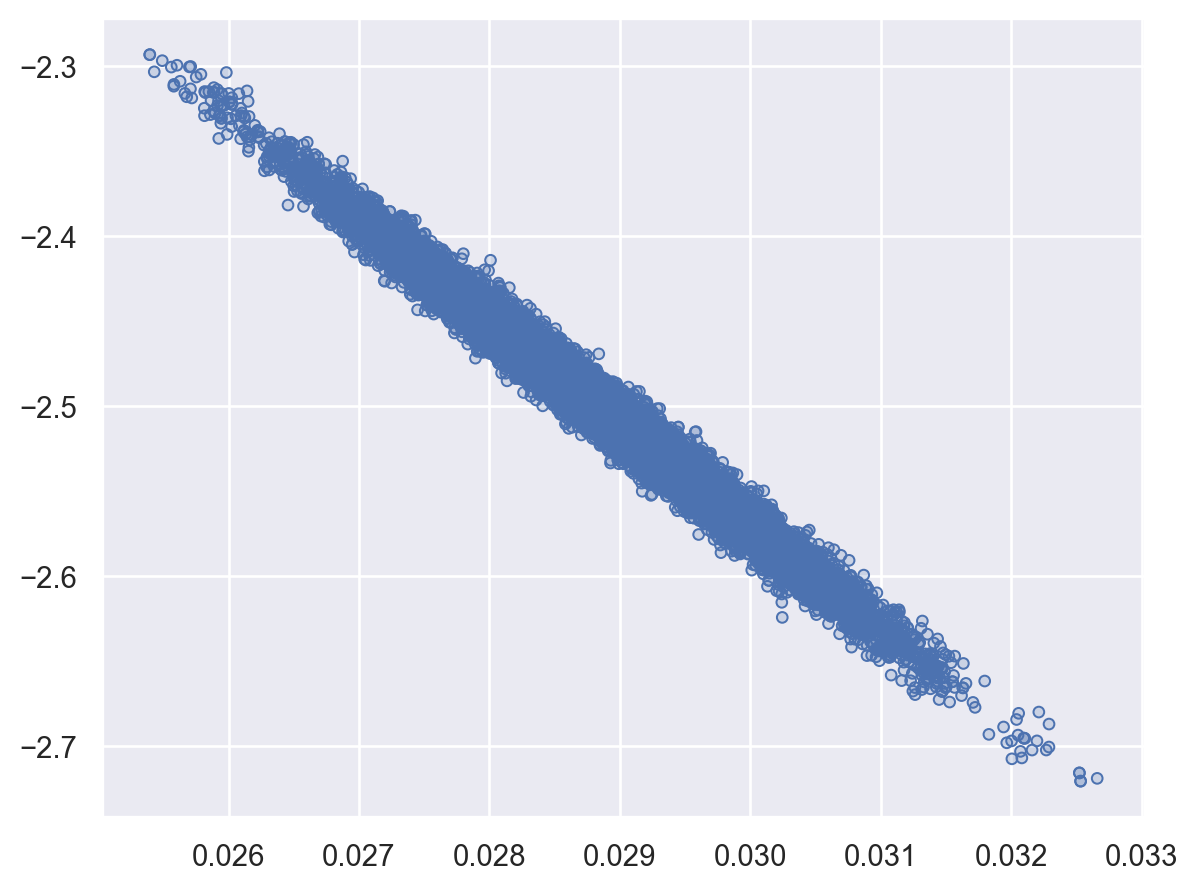

In [25]:
so.Plot(x=idata_register.posterior["a"].to_numpy().flatten(), y=idata_register.posterior["b"].to_numpy().flatten()).add(so.Dots())

# Checking the model: simulate data

So how good (or bad) are these models really?
There are several ways to check this but one very intuitive way is to do a "simulation"
and generate new data with our models.
If the models tell a good generative story about the dataset,
then they should also generate new data that looks somewhat like our observations.
With probabilistic programs, it is particularly easy to do this since they already have a generative form.
And probabilistic programming libraries provide special tools for sampling from the *posterior predictive* distribution,
i.e. the distribution of *new data* after observing old data:

$p(x' | \vec{x})$

In PyMC, we do this by taking our posterior samples and then sampling a new observation for each posterior sample that we have.
Since our observations are already arrays, we would normally get many more observations in total then we have originally
namely `n_obs * n_samples`.
However, we can also choose to generate fewer new points for each posterior sample.

## By Voice

We can reuse our per-voice model,
but in order to avoid sampling too many new observations, we replace the input data that is used:
instead of a huge array with many examples of each voice,
we only sample one observation per voice for each sample, so `staff` becomes `[0,1,2,3]`.
For `obs`, we just provide a dummy array since we resample its values anyways.

In [26]:
with model_voice:
    pm.set_data({"data_staff": [0,1,2,3], "data_obs": [1, 1, 1, 1]})
    pm.sample_posterior_predictive(idata_voice, extend_inferencedata=True)

idata_voice

Sampling: [obs]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

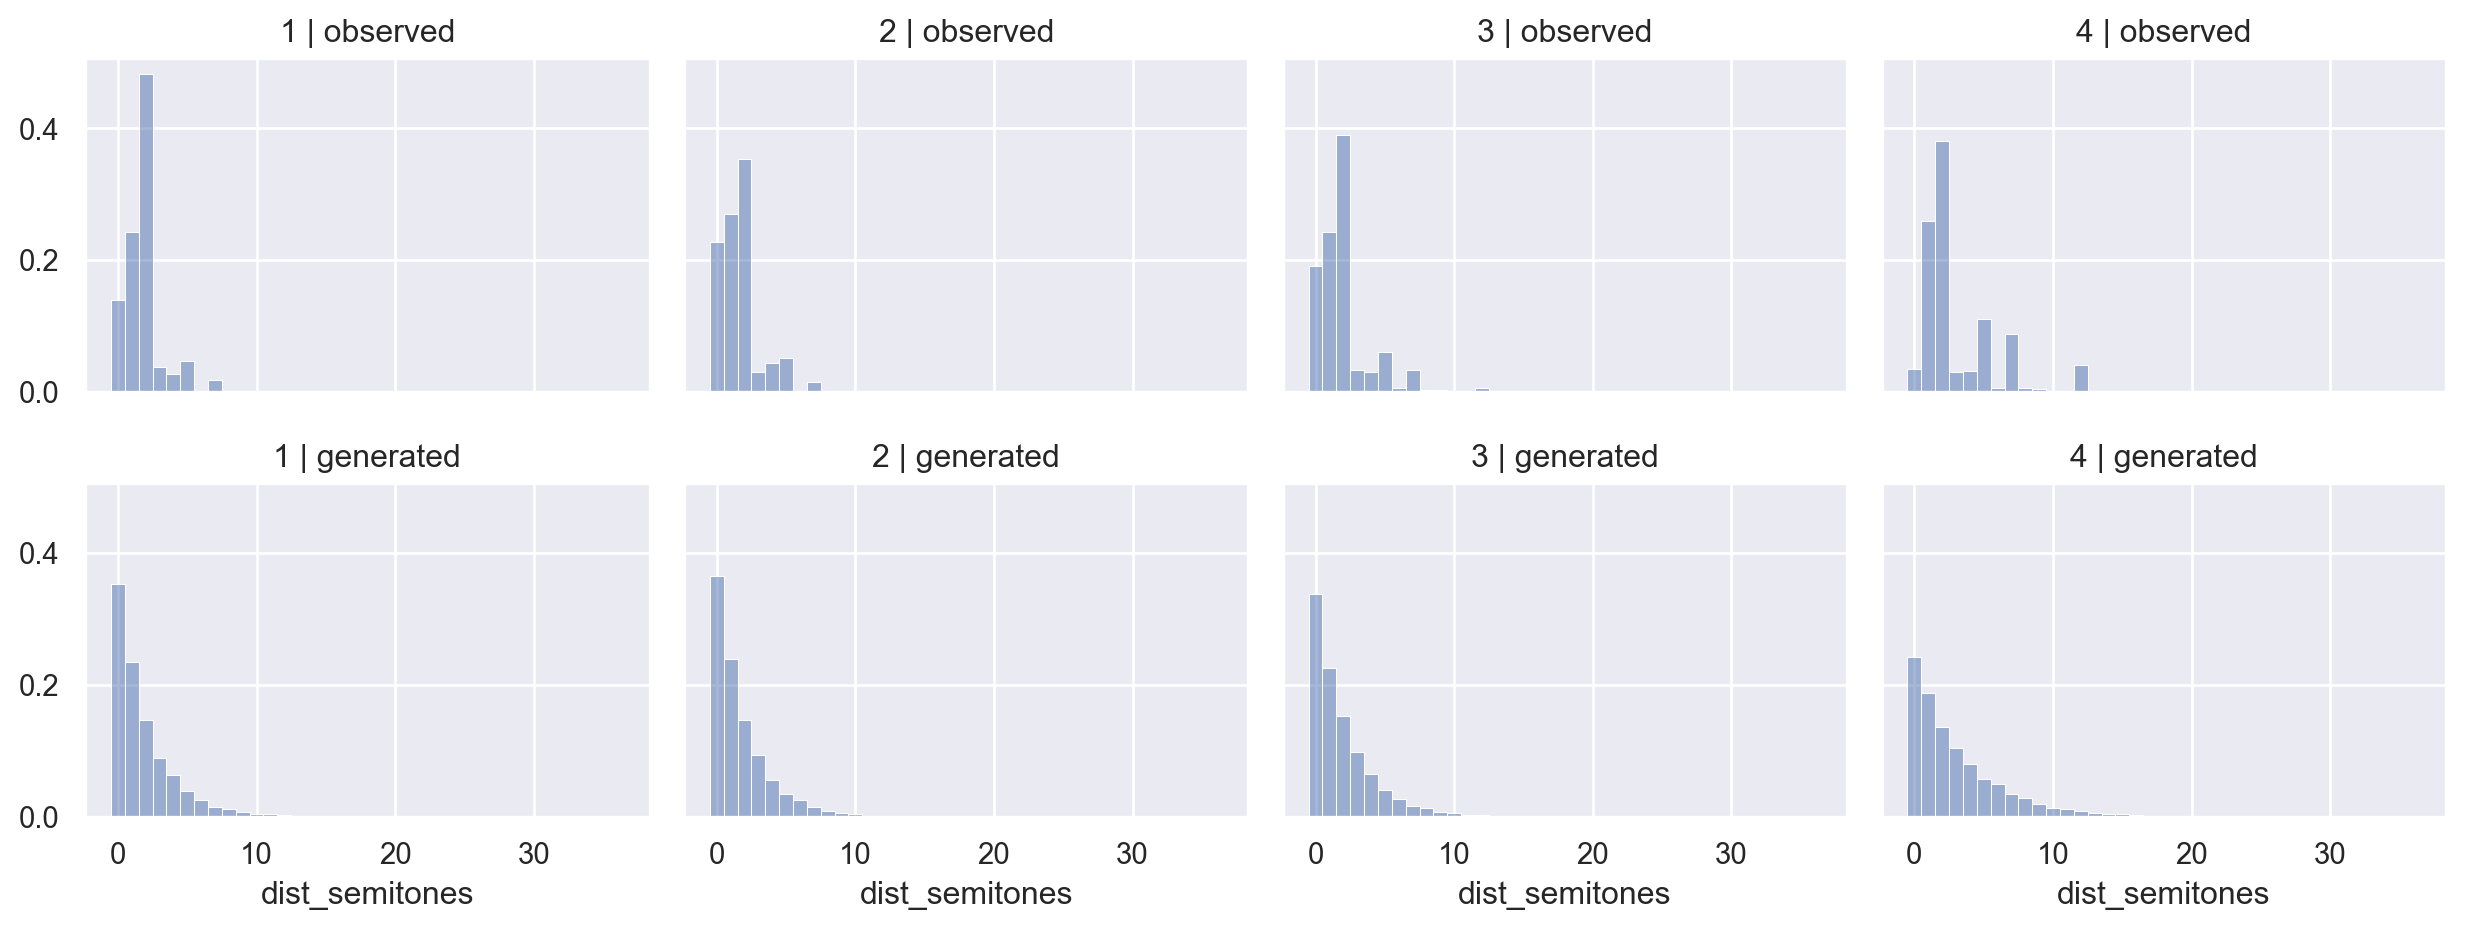

In [27]:
def plot_compare_voice(idata, original):
    gen_samples = idata.posterior_predictive["obs"].to_numpy().flatten()
    n_chains = idata.posterior_predictive.dims["chain"]
    n_draws = idata.posterior_predictive.dims["draw"]
    gen_df = pd.DataFrame({
        "staff": np.tile([1,2,3,4], n_chains * n_draws),
        "dist_semitones": gen_samples-1,
        #"bigram_id": np.repeat(np.arange(n_chains * n_draws), 4)
    })
    df_voice = pd.concat((original.reset_index(), gen_df),
                         join="inner",
                         keys=["observed", "generated"],
                         names=["source", "sample"])

    return (
        so.Plot(df_voice, x="dist_semitones")
            .facet(row="source", col="staff")
            .add(so.Bars(alpha=0.5), so.Hist("density", discrete=True))
            #.add(so.Line(), so.KDE())
            .layout(size=(13,5))
    )

plot_compare_voice(idata_voice, dists)

We can observe that the different $\theta$s for the different voices also correspond to different widths in the observed distributions,
so the model is able to reflect this aspect of the data.
On the other hand, there are still big differences between the observed distributions and the inferred ones.
For example, $0$ (unison) is usually way to common in the model compared to steps (1 or 2 semitones),
which is a problem of the geometric distribution.
Another aspect is that there seem to be "systematic outliers", e.g., some voices have little bumps at 5 (4th), 7 (5th) and 12 (octave).
A better model would probably take the special functions of steps as well as perfect intervals into account!

## By Register

For the register model, we use the same procedure as above,
but this time we draw one observation for each $p_0$ at each posterior sample.

In [28]:
p0_range = np.arange(p0.min(), p0.max()+1)

with model_register:
    pm.set_data({"data_p0": p0_range, "data_obs": np.ones(p0_range.shape, dtype=int)})
    pm.sample_posterior_predictive(idata_register, extend_inferencedata=True)

idata_register

Sampling: [obs]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

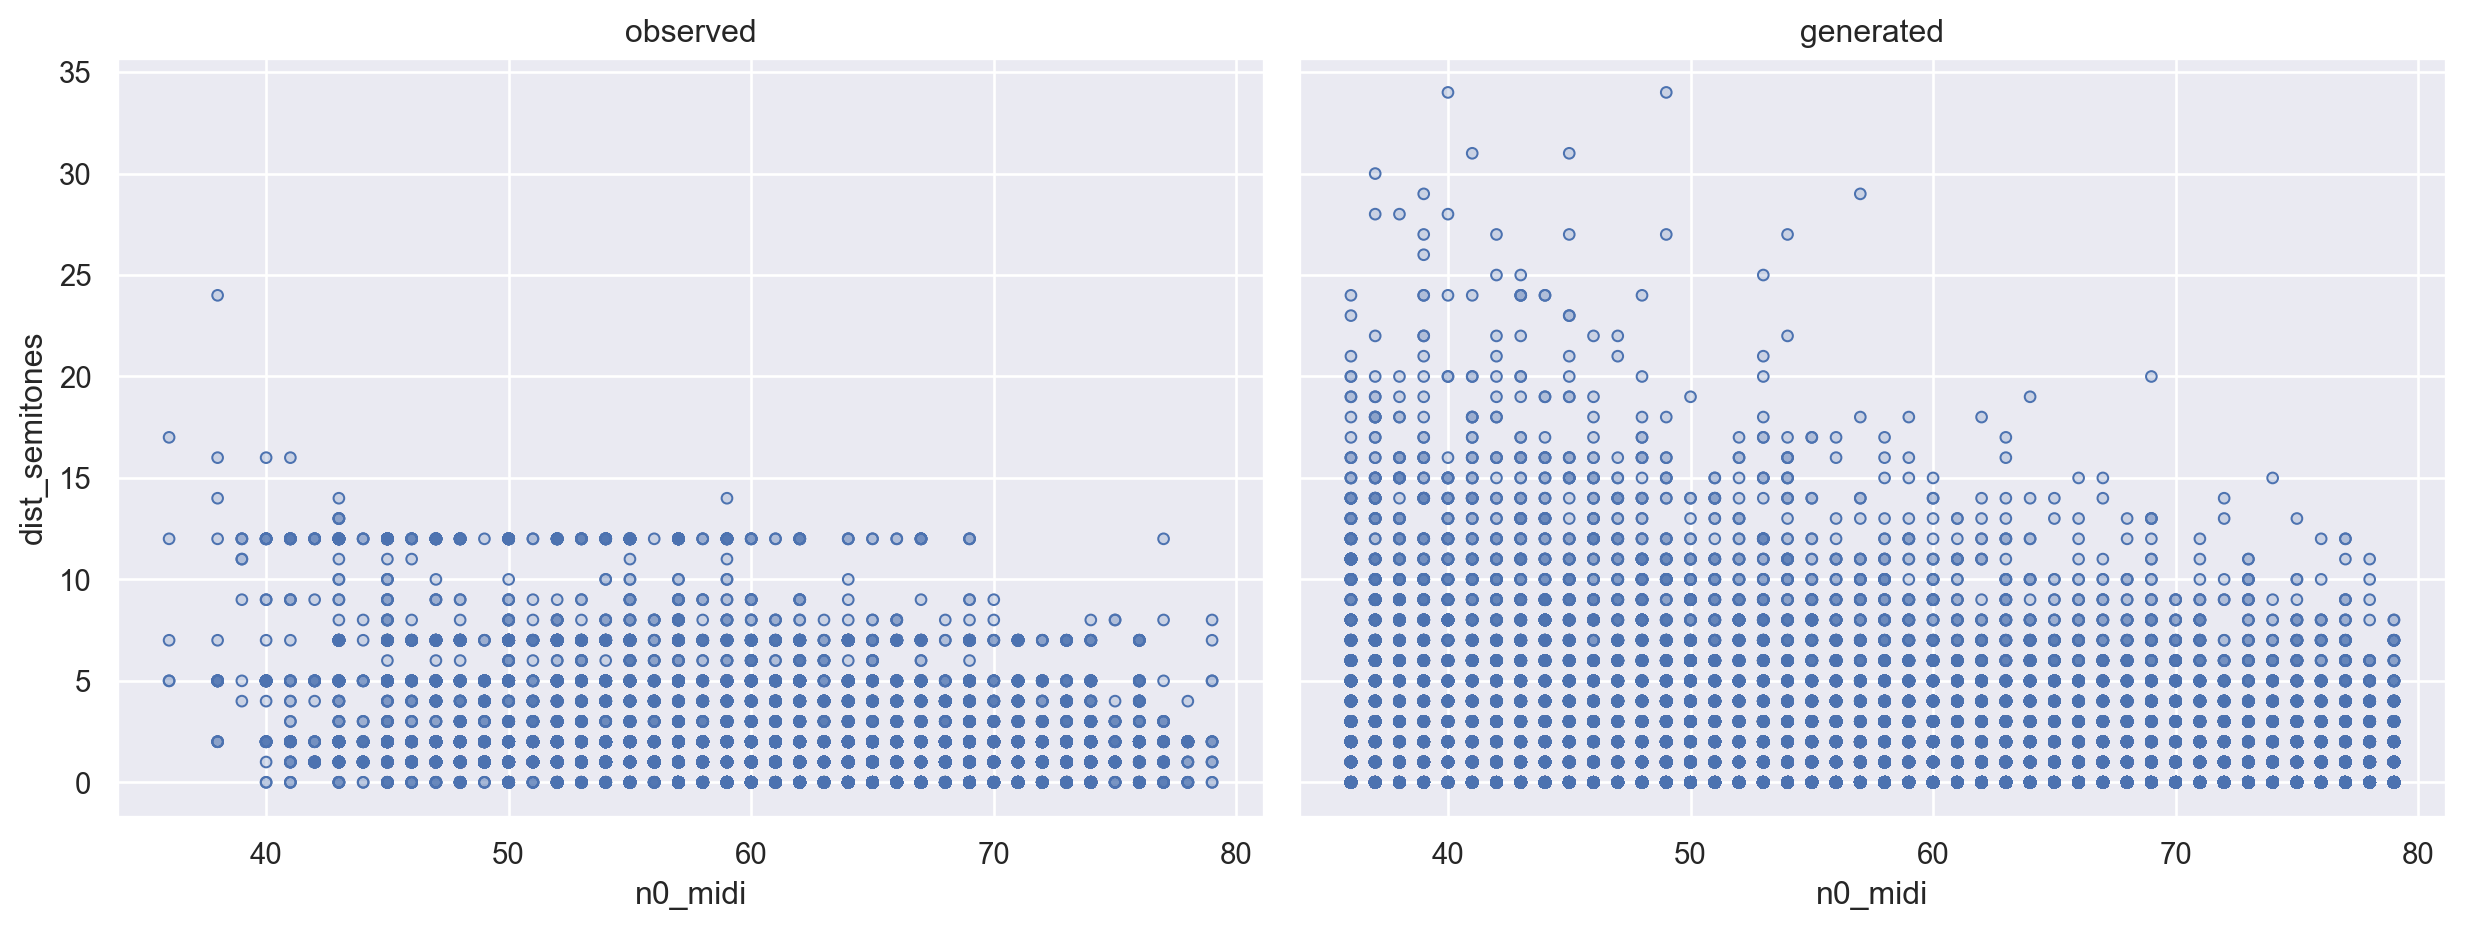

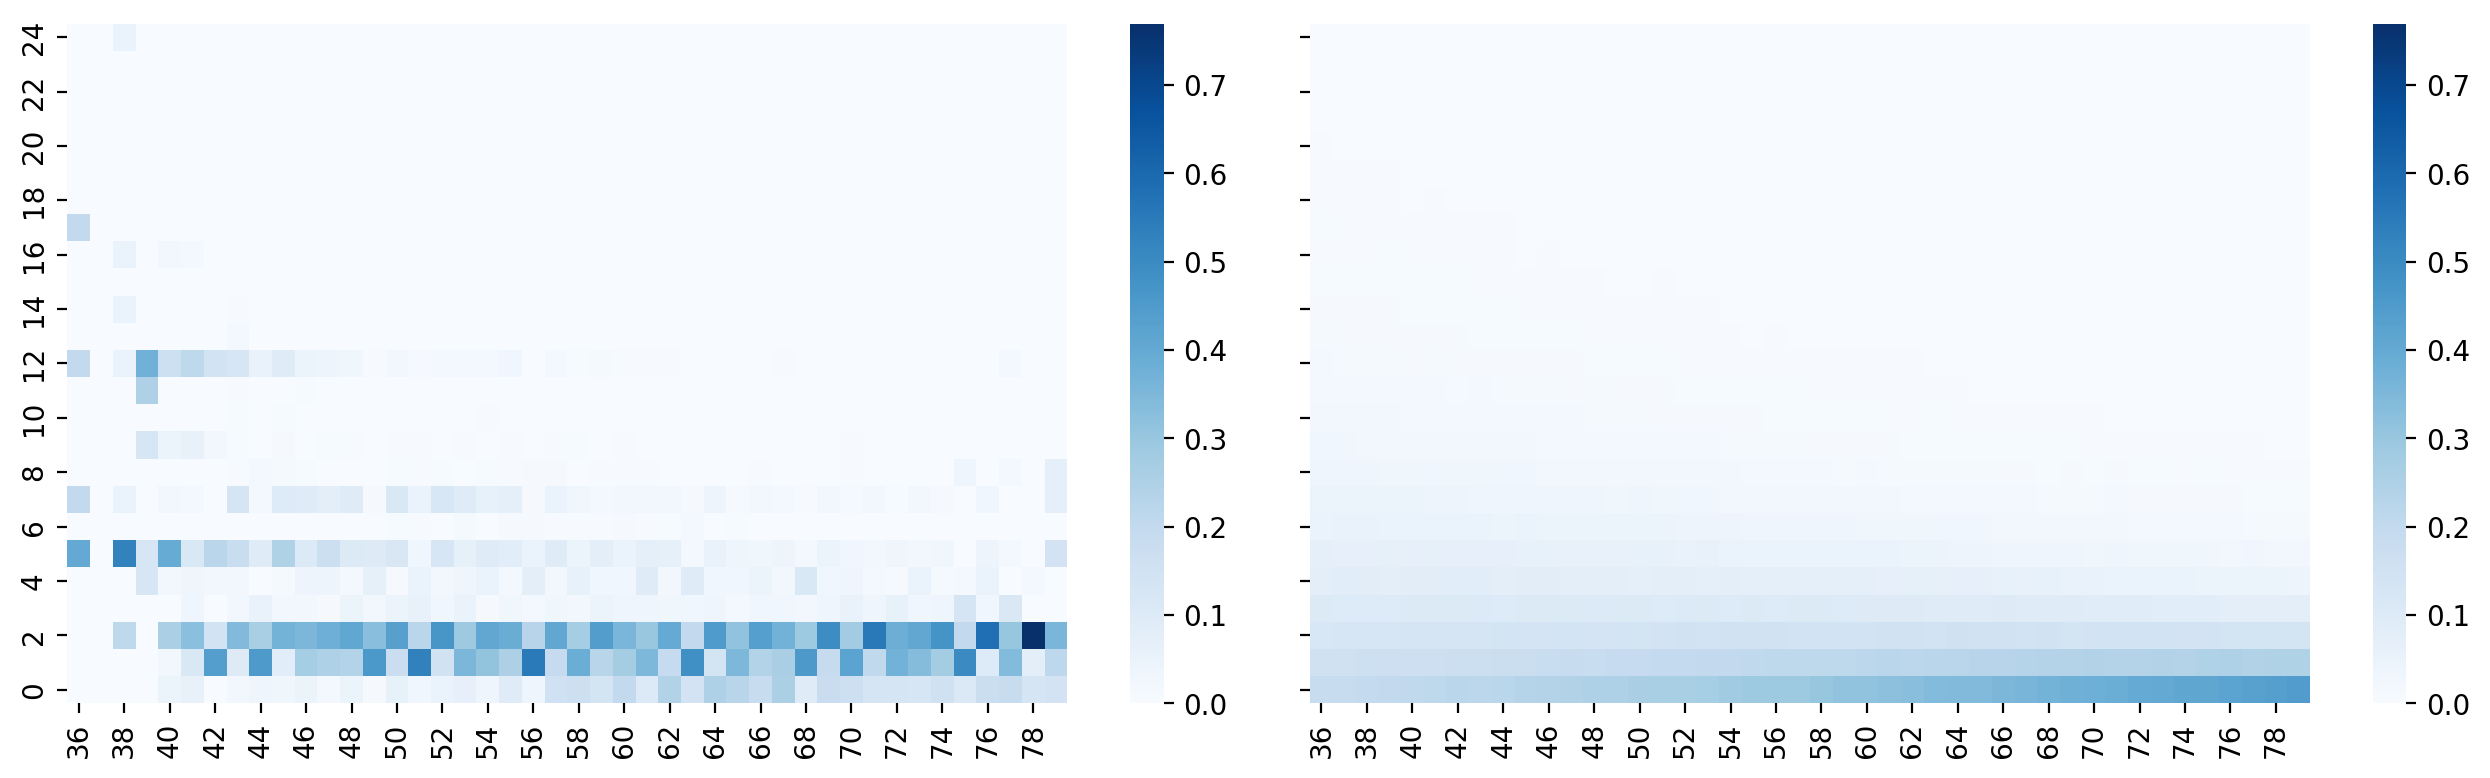

In [29]:
def plot_data_vs_generated(idata, original):
    gen_register = idata.posterior_predictive["obs"].to_numpy().flatten()
    n_chains = idata.posterior_predictive.dims["chain"]
    n_draws = idata.posterior_predictive.dims["draw"]
    gen_df = pd.DataFrame({
        "n0_midi": np.tile(p0_range, n_chains*n_draws),
        "dist_semitones": gen_register.flatten()-1,
        #"sample": np.repeat(np.arange(n_chains*n_draws), len(p0_range))
    })
    # combine dataframes, downsample generated to common size
    subsample = rng.choice(np.arange(len(p0_range)*n_chains*n_draws), len(original), replace=False)
    df = pd.concat([original.reset_index(), gen_df.iloc[subsample]], join="inner", keys=["observed", "generated"], names=["source", "sample"])

    def cond_hist(data):
        p0 = data.n0_midi
        dist = data.dist_semitones
        xmin, xmax = p0.min(), p0.max()
        ymin, ymax = dist.min(), min(24, dist.max())
        
        hist, xedges, yedges = np.histogram2d(p0, dist, range=[[xmin-0.5, xmax+0.5], [ymin-0.5, ymax+0.5]], bins=(xmax-xmin+1, ymax-ymin+1))
        marg = hist.sum(axis=1, keepdims=True)
        marg[marg==0] = 1
        hist_cond = hist / marg
        return pd.DataFrame(data=hist_cond.T, columns=np.arange(xmin, xmax+1), index=np.arange(ymin, ymax+1))
        
    def plot_hist(ax, df, vmax, cbar=True):
        sns.heatmap(df, ax=ax, cmap="Blues", vmin=0, vmax=vmax, cbar=cbar)

    hist_orig = cond_hist(original)
    hist_gen = cond_hist(gen_df)
    vmax = max(hist_orig.max(axis=None), hist_gen.max(axis=None))
    
    fig, ax = plt.subplots(1, 2, figsize=(13,4), sharex=True, sharey=True)
    plot_hist(ax[0], hist_orig, vmax)
    plot_hist(ax[1], hist_gen, vmax)
    ax[0].invert_yaxis()
    fig.tight_layout()
    # return fig
    return so.Plot(df, x="n0_midi", y="dist_semitones").facet("source").add(so.Dots()).layout(size=(13,5))

plot_data_vs_generated(idata_register, dists)

We can make similar observations as above. The general tendency seems to be right,
but the model still doesn't capture a lot of the structure in the data, e.g. the bands at 5, 7, and 12.
In addition, there seems to be some "checkerboard" structure in the steps:
some pitches are followed by halftone steps, others by wholetones.
This could be caused by a bias in the keys that Bach uses, e.g. a preference for stem tones.
Generally, the original distribution is much more focussed on particular interval sizes than the relatively smooth model distribution.

(Note that the upper plot is a bit misleading about the variance of the given vs. the generated data.
We still have many more generated samples than given observations, so it's much more likely to sample larger intervals,
and the scatter plot isn't very good at showing that.
It's more apparent in the heatmap plot below, which is normalized by column, so each column shows the distribution $p(x|p_0)$.)

# Model Comparison

So both models capture some but not all of the structure of the data.
But which works better or is more plausible?
There are several ways of finding that out, but the most elegant one (in the Bayesian framework) is probably the following:
Assessing the plausibility of a model (compared to others) is again an *inference*.
So if we had a variable that expresses the "true model", we could use Bayesian inference to draw conclusions about this "true model".
In other words, we could obtain a posterior distribution that tells us how plausible each of the models is.

That is exactly what we are going to do here.
We build a *meta mode* that contains all three models above as well as a variable for the model choice.
The observations are then sampled from one of the submodels depending on the model that was chosen:
- Choose $m \sim Categorical(\frac{1}{3}, \frac{1}{3}, \frac{1}{3})$
- If $m$ is
  - $0$: sample $x$ from model 1
  - $1$: sample $x$ from model 2
  - $2$: sample $x$ from model 3

Using the posterior $p(m | x)$, we can then compute the [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor) between two models:

$\dfrac{p(m_1 | x) p(m_2)}{p(m_2 | x) p(m_1)} = \dfrac{p(x | m_1)}{p(x | m_2)}$.

The Bayes factor expresses the evidence that the data provides for $m_1$ over $m_2$.
It therefore factors out the prior of the models.
However, if we assume a uniform prior, those cancel out anyways.

Below we look at two ways of computing the posterior $p(m | x)$,
once using variational inference, and once using sampling (but in several steps).

## Variational Inference (using `pyro`)

Variational inference works a little bit differently from sampling, but it follows the same goal,
namely estimating the posterior distribution $p(z|x)$.
While sampling uses MCMC (or some other sampling method) to draw samples from the posterior distribution,
variational inference defines a *variational distribution* $q_\phi(z)$
that has some parameters $\phi$ that can be tuned.
It then tries to optimize these parameters so that $q_\phi(z)$ becomes as similar as possible to $p(z|x)$.
This is usually done through some form of automatic differentiation and gradient descent.
The result is than a fitted $q_\phi(z)$ that approximates the true posterior, instead of a set of samples.

In the example below, we will use `pyro`, which is specialized on automatic differentiation variational inference (ADVI).
The specification of a model looks very similar to PyMC, but with a number of differences:
- A model is not represented as an object that is build up step by step, but as *function*.
  This is a bit more flexible since this function can (in principle) contain arbitrary code.
  As before, the function is written as if it generates the data,
  but running it in different contexts (e.g. during inference) does slightly different things behind the scenes
- Variables are sampled using the general `pyro.sample()`, which is given a distribution object.
- We use "plates" to explicitly denote iid variables (iid = "inpedentently and identically distributed")
  instead of `shape=...` or implicit vectorization.
Besides that, the model below looks pretty much like it would in PyMC.
The model choice is implemented by first building a combined matrix for $\theta$, where one dimension corresponds to the data points
(and thus encodes the variation in voice or $p_0$),
and the other dimension corresponds to the model.
When sampling the observations, we can then use `model_choice` to index into this combined array to pick the right $\theta$.

In [30]:
# the model is specified as a function (an actual probabilistic program!)
# but looks very similar to PyMC otherwise (samples every variable from a distribution)

def model_meta_pyro(obs, staff, p0, n_voices=4, logging=False):
    # global model
    theta_global = pyro.sample("theta_global", dist.Beta(0.5, 0.5))

    # voice model
    with pyro.plate("voices", n_voices):
        theta_voice = pyro.sample("theta_voice", dist.Beta(0.5, 0.5))

    # register model
    a = pyro.sample("a", dist.Normal(0, 1000))
    b = pyro.sample("b", dist.Normal(0, 1000))
    theta_register = 1 / (1 + torch.exp(-(p0*a + b)))

    # combine the thetas of different models -> can then be chosen through theta[model_choice]
    global_b = torch.broadcast_to(theta_global, theta_register.shape)
    theta = torch.stack((
        global_b,                # model 1
        theta_voice[..., staff], # model 2
        theta_register           # model 3
    ),dim=-2)
    
    # choice of model, uniform between 0 (global), 1 (voice), and 2 (register)
    model_choice = pyro.sample("model", dist.Categorical(torch.ones(3)/3.0), infer={"enumerate": "parallel"})
    
    # make the observations
    with pyro.plate("observations", size=len(obs)) as i:
        obs = pyro.sample("obs", dist.Geometric(theta[..., model_choice, i]), obs=obs[i])

The biggest difference between sampling and VI is that we somehow have to define a variational distribution $q_\phi(z)$.
PyMC has various strategies for deriving $q$ from the model specification.
Pyro, on the other hand, uses a more flexible approach and lets the user derine `q` themselves,
again as a function that samples all variables `z`.
In addition to sampling $z$ (using `pyro.sample()`),
this "guide" function also keeps track of the parameters $\phi$
that we want to optimize and their initial values (using `pyro.param()`).

It is usually beneficial to pick initial values that are somewhat close to the expected final values,
so we will use some estimates from the samples that we have obtained above.
Note, however, that unlike the prior, these initial values are not part of the model specification.
Without them, we would normally still converge to the same result in the limit, it would just take much longer.

The guide, like the model, is just a function, and the two are expected to take the same arguments.
Below, we wrap the guide into a factory function to make it a bit easier to apply the initial parameter values.

In [31]:
def make_guide_meta(init):
    # get the initial parameter estimates
    ialpha_g = torch.tensor(init["theta_global"][0]).float()
    ibeta_g = torch.tensor(init["theta_global"][1]).float()
    ialpha_v = torch.tensor(init["theta_voice"][0]).float()
    ibeta_v = torch.tensor(init["theta_voice"][1]).float()
    imu_a = torch.tensor(init["a_register"][0]).float()
    imu_b = torch.tensor(init["b_register"][0]).float()
    isigma_a = torch.tensor(init["a_register"][1]).float()
    isigma_b = torch.tensor(init["b_register"][1]).float()

    # the actual guide
    def guide(obs, staff, p0, n_voices=4, logging=False):
        # model choice
        p_model = pyro.param("p_model", torch.ones(3)/3, constraint=dist.constraints.simplex)
        pyro.sample("model", dist.Categorical(p_model), infer={"enumerate": "parallel"})
        
        # parameters for global model
        alpha_global = pyro.param("alpha_global", ialpha_g, constraint=dist.constraints.positive)
        beta_global = pyro.param("beta_global", ibeta_g, constraint=dist.constraints.positive)
        theta_global = pyro.sample("theta_global", dist.Beta(alpha_global, beta_global))
    
        # parameters for voice model
        alpha_voice = pyro.param("alpha_voice", ialpha_v, constraint=dist.constraints.positive)
        beta_voice = pyro.param("beta_voice", ibeta_v, constraint=dist.constraints.positive)
        with pyro.plate("voices", n_voices):
            theta_voice = pyro.sample("theta_voice", dist.Beta(alpha_voice, beta_voice))
    
        # parameters for register model
        mu_a = pyro.param("mu_a", imu_a)
        mu_b = pyro.param("mu_b", imu_b)
        sigma_a = pyro.param("sigma_a", isigma_a, constraint=dist.constraints.positive)
        sigma_b = pyro.param("sigma_b", isigma_b, constraint=dist.constraints.positive)
        a = pyro.sample("a", dist.Normal(mu_a, sigma_a))
        b = pyro.sample("b", dist.Normal(mu_b, sigma_b))

    return guide

In [32]:
# estimate the initial parameters using the samples drawn above
def estimate_params(idata_global, idata_voice=None, idata_register=None):
    idata_voice = idata_voice or idata_global
    idata_register = idata_register or idata_global
    
    params = dict()
    params["theta_global"] = estimate_beta(idata_global["theta_global"])
    params["theta_voice"] = estimate_beta(idata_voice["theta_voice"])
    params["a_register"] = (idata_register["a"].mean().item(), idata_register["a"].std().item())
    params["b_register"] = (idata_register["b"].mean().item(), idata_register["b"].std().item())
    return params

init_params = estimate_params(idata_simple.posterior, idata_voice.posterior, idata_register.posterior)

The optimization of $q_\phi$ is then done with classical gradient descent.
Here, we track the losses as well as the parameter `p_model` (which contains the model probabilities)
to observe its development over time and see, if it converges.

In [33]:
def run_meta_svi(obs, staff, p0, init_params):
    # convert inputs to torch tensors
    obs = torch.tensor(obs)
    staff = torch.tensor(staff)
    p0 = torch.tensor(p0)

    # clear the parameters (must be done between inference runs)
    pyro.clear_param_store()

    # set up optimizer and loss
    optim = pyro.optim.Adam({"lr": 0.001, "betas": [0.9, 0.999]})
    svi = pyro.infer.SVI(model_meta_pyro, make_guide_meta(init_params), optim, loss=pyro.infer.TraceEnum_ELBO(num_particles=2,vectorize_particles=True))

    # run the inference for a certain number of steps, collect losses and some parameter histories
    n_steps = 10_000
    losses = []
    hist_p_model = np.zeros((n_steps, 3))
    for step in tqdm.notebook.tnrange(n_steps):
        # take a step
        loss = svi.step(obs, staff, p0)
        # record the current loss
        losses.append(loss)
        # record the current value of p_model
        hist_p_model[step] = pyro.param("p_model").detach()

    # return the histories
    return losses, hist_p_model

losses, hist_p_model = run_meta_svi(observations, staff, p0, init_params)

  0%|          | 0/10000 [00:00<?, ?it/s]

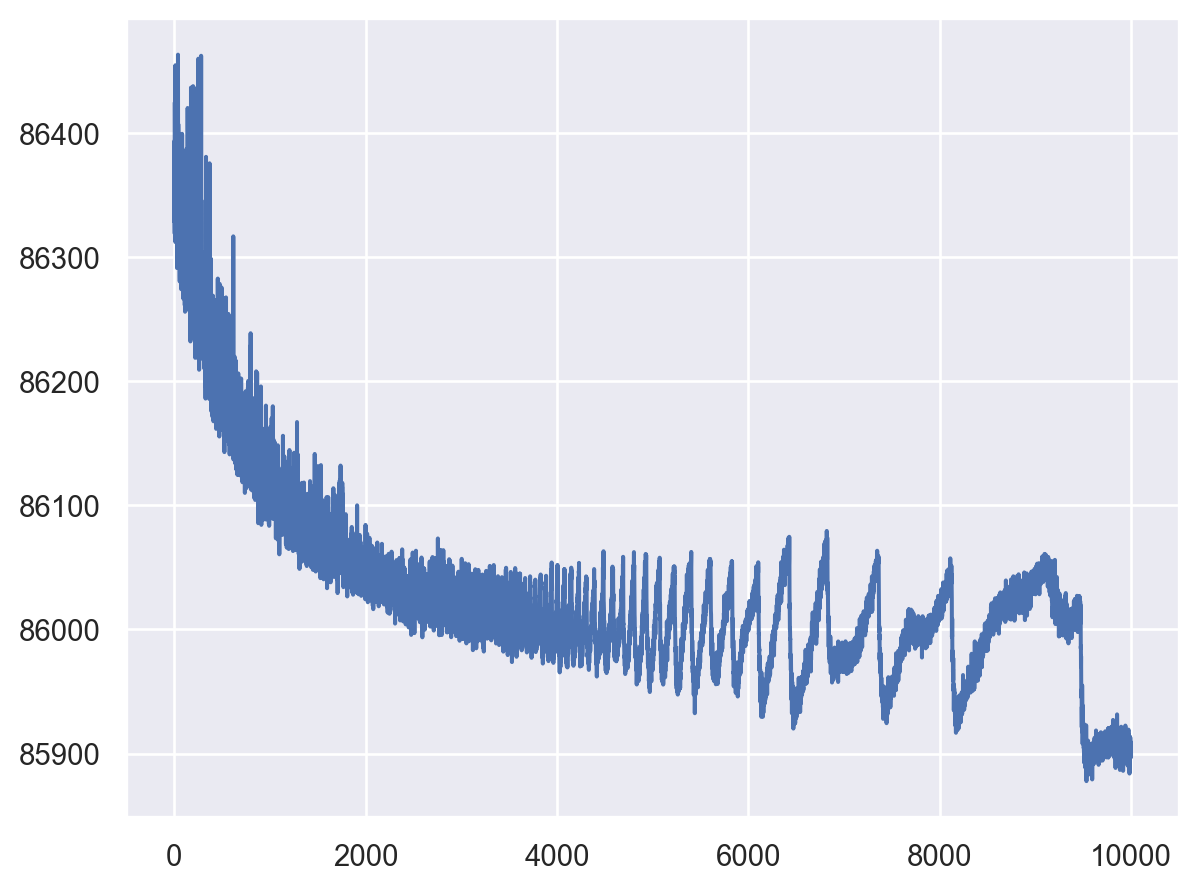

In [34]:
so.Plot(x=range(len(losses)), y=losses).add(so.Line())

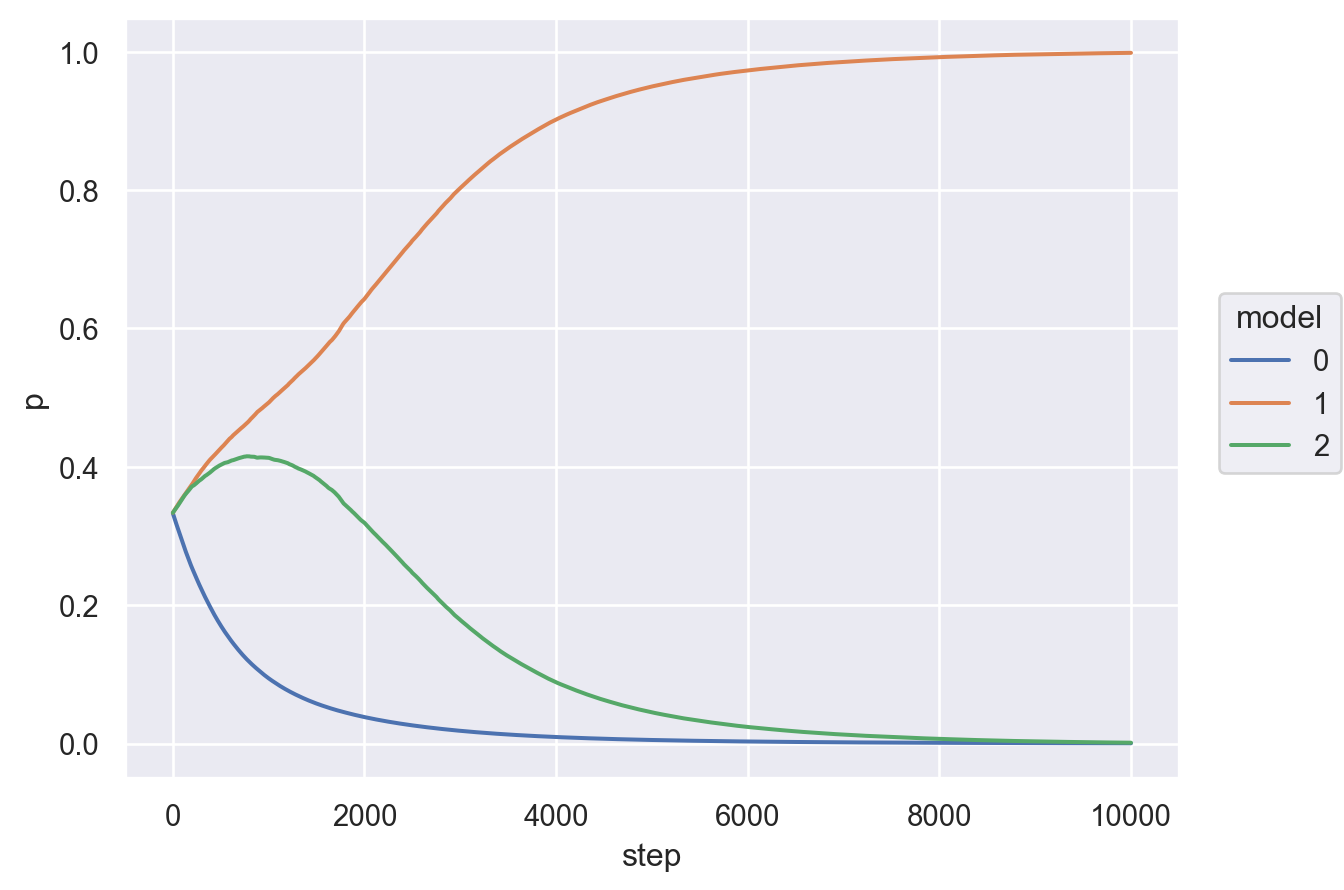

In [35]:
# plot the history of p_model, i.e. the probability assigned to each model during training
df_hist_p_model = (
    pd.DataFrame(data=hist_p_model)
        .reset_index(names="step")
        .melt(id_vars="step", var_name="model", value_name="p")
)
so.Plot(df_hist_p_model, x="step", y="p", color="model").add(so.Line()).scale(color=so.Nominal())

As you can see, the meta model pretty clearly converges to preferring model 1 (per-voice) over the other two models.
The difference is not always so pronounced, it could also have converged on something like 0.7 to 0.2 to 0.1,
if that is closer to the true posterior.
But what we observe here means that we can be pretty sure that model 1 is much more plausible than the others
for this dataset.

## Stepwise Model Inference (`numpyro`)

Can we obtain the same results using classical sampling?
That can be tricky!
If we try to naively use the same meta model with MCMC,
we will observe something strange:
For each chain, the model will pick exactly one submodel (randomly)
and since only that submodel gets a chance to "learn" something useful about its parameters,
it will become immediately much better than the other two.
As a consequence, the chain will never again chose any of the unlucky two models and just stick to the first one it chose.
That is of course not very useful.

What we can do instead is to sample in two steps.
First, we obtain meaningful samples for the parameters of each model (as above).
Then we use these samples to sample from the posterior of the model choice variable.
(We have to make sure that this procedure gives us the correct posterior for the model choice.
If you want, you can verify this yourself by writing down the posterior $p(m|x)$
in terms of the submodels and their parameters.)

We will now perform this two-step inference using numpyro, a variant of pyro that is a bit more efficient when using traditional sampling.
Think of it as doing what PyMC does but with the syntax of pyro.
The meta-model is basically identical to the pyro model above, but using `jax` instead of `torch` for vectors.

In [36]:
def model_meta_numpyro(obs, staff, p0):
    # parameters for global model
    theta_global = numpyro.sample("theta_global", ndist.Beta(0.5, 0.5))

    # parameters for voice model
    with numpyro.plate("voices", 4, dim=-1):
        theta_voice = numpyro.sample("theta_voice", ndist.Beta(0.5, 0.5))

    # parameters for register model
    a = numpyro.sample("a", ndist.Normal(0, 10))
    b = numpyro.sample("b", ndist.Normal(0, 10))
    theta_register = 1 / (1 + jnp.exp(-(p0*a + b)))

    # combine the thetas of different models -> can then be chosen through theta[model_choice]
    theta = jnp.stack((
        jnp.full(p0.shape, theta_global), # model 1
        theta_voice[staff],               # model 2
        theta_register                    # model 3
    ))
    
    # choice of model, uniform between 0 (global), 1 (voice-dependent), and 2 (register-dependent)
    model_choice = numpyro.sample("model", ndist.CategoricalProbs(jnp.ones(3)/3.0), infer={"enumerate": "parallel"})
    
    # make the observations
    with numpyro.plate("observations", size=len(obs)) as i:
        obs = numpyro.sample("obs", ndist.Geometric(Vindex(theta)[model_choice, i]), obs=obs[i])

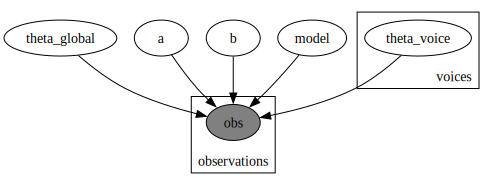

In [37]:
numpyro.render_model(model_meta_numpyro, (jnp.array(observations), jnp.array(staff), jnp.array(p0)))

In addition to the full meta model, we also define an auxiliary model
that is just a combination of the three submodels.
It doesn't have a model choice, each of the submodels uses its own set of observations,
and it's only used to draw samples for the submodel parameters.
You can see how its architecture differs from the meta model in the diagram below.

In [38]:
# define models in numpyro
def model_simple_numpyro(obs):
    theta = numpyro.sample("theta_global", ndist.Beta(0.5, 0.5))
    #jax.debug.print("- theta_global: {t}", t=theta)
    obs = numpyro.sample("obs_global", ndist.Geometric(theta), obs=obs)

def model_voice_numpyro(obs, staff, nstaves=4):
    with numpyro.plate("voices", nstaves):
        theta = numpyro.sample("theta_voice", ndist.Beta(0.5, 0.5))
    #jax.debug.print("- theta_voice: {t}", t=theta)
    obs = numpyro.sample("obs_voice", ndist.Geometric(theta[staff]), obs=obs)

def model_register_numpyro(obs, p0):
    a = numpyro.sample("a", ndist.Normal(0, 10))
    b = numpyro.sample("b", ndist.Normal(0, 10))
    theta = 1 / (1 + jnp.exp(-(p0*a + b)))
    #jax.debug.print("- a: {a}\n- b: {b}", a=a, b=b)
    #jax.debug.print("- theta_register: {t}", t=theta)
    obs = numpyro.sample("obs_register", ndist.Geometric(theta), obs=obs)

# helper model: runs all submodels independently 
def model_joint_numpyro(obs, staff, p0):
    model_simple_numpyro(obs)
    model_voice_numpyro(obs, staff)
    model_register_numpyro(obs, p0)

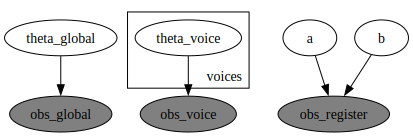

In [39]:
numpyro.render_model(model_joint_numpyro, (jnp.array(observations), jnp.array(staff), jnp.array(p0)))

Now we perform the two inference steps.
First, we run MCMC (with the NUTS sampler, as PyMC did above)
to obtain our parameter samples for the three submodels.
Then, we use the `Predictive` class of numpyro to draw samples for `model`, the model-choice variable.

In [40]:
def run_meta_numpyro(obs, staff, p0):
    # convert data to jax arrays
    obs = jnp.array(obs)
    staff = jnp.array(staff)
    p0 = jnp.array(p0)
    
    n_chains = 2
    n_samples = 5000
    n_warmup = 1000

    # draw samples for the submodel parameters
    kernel = numpyro.infer.NUTS(model_joint_numpyro)
    mcmc = numpyro.infer.MCMC(kernel, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains)
    mcmc.run(rng_key, obs, staff, p0)

    # draw samples of the model choice: reuse the posterior samples in the main model
    posterior_samples = mcmc.get_samples()
    predictive = numpyro.infer.Predictive(model_meta_numpyro, posterior_samples, infer_discrete=True, return_sites=["model"])
    discrete_samples = predictive(rng_key, obs, staff, p0)

    # merge model samples
    chain_discrete_samples = jax.tree_util.tree_map(
        lambda x: x.reshape((n_chains, n_samples) + x.shape[1:]),
        discrete_samples)
    mcmc.get_samples().update(discrete_samples)
    mcmc.get_samples(group_by_chain=True).update(chain_discrete_samples)
    
    return mcmc

mcmc_meta = run_meta_numpyro(observations, staff, p0)
idata_meta = az.from_numpyro(mcmc_meta)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [41]:
# no samples of "model" in here, since it's marginalized out
mcmc_meta.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
             a      0.03      0.00      0.03      0.03      0.03   8056.26      1.00
             b     -2.50      0.06     -2.50     -2.60     -2.41   8073.71      1.00
  theta_global      0.32      0.00      0.32      0.31      0.32   9651.69      1.00
theta_voice[0]      0.35      0.00      0.35      0.34      0.36   8251.52      1.00
theta_voice[1]      0.37      0.00      0.37      0.37      0.38   8808.24      1.00
theta_voice[2]      0.34      0.00      0.34      0.33      0.35   8496.03      1.00
theta_voice[3]      0.24      0.00      0.24      0.24      0.25   8919.32      1.00

Number of divergences: 0


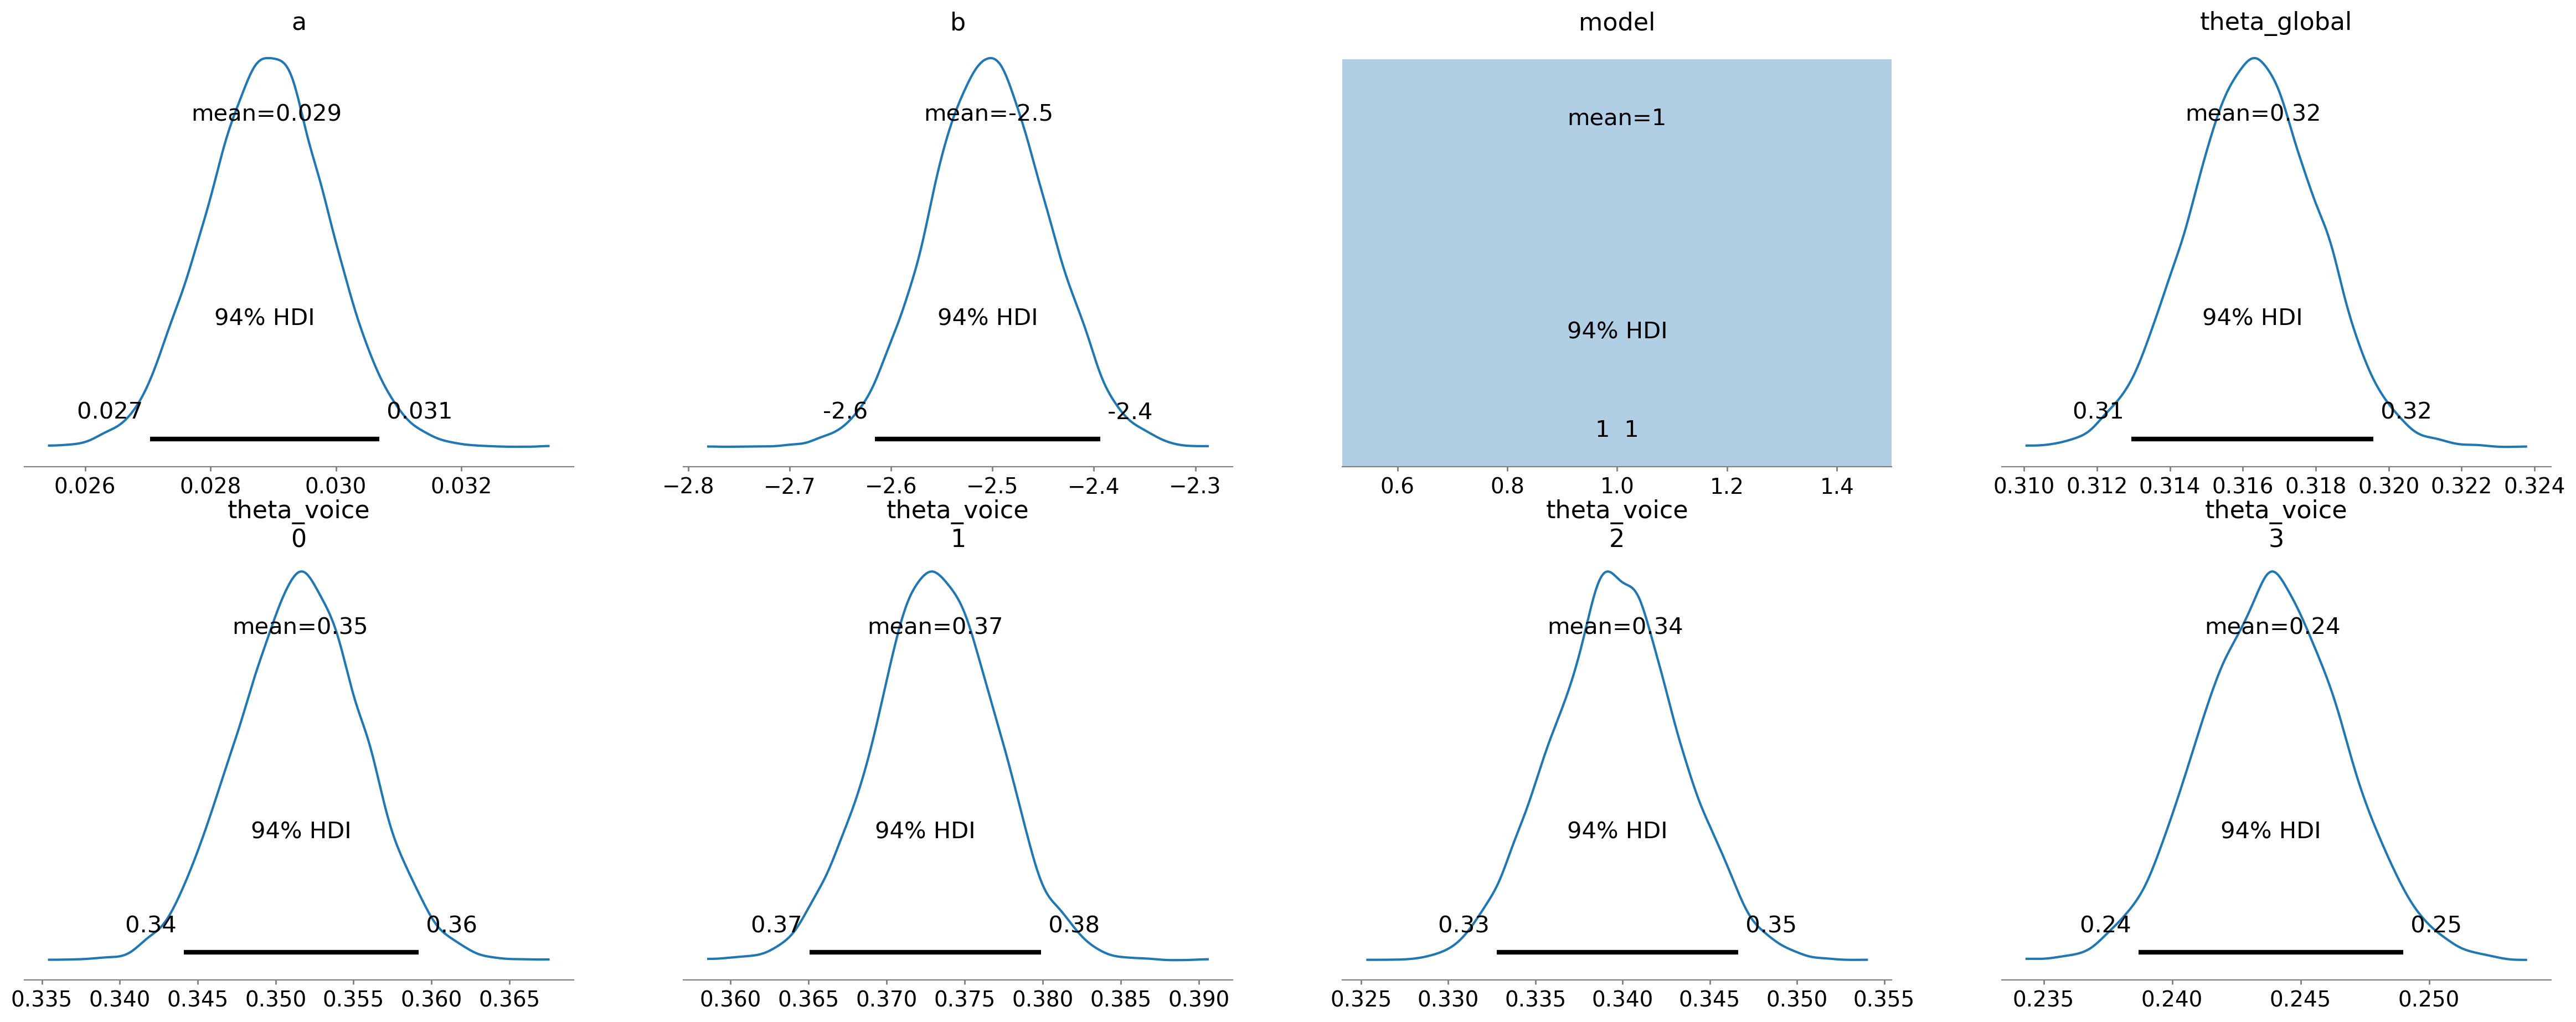

In [42]:
az.plot_posterior(idata_meta);

As it turns out, all the samples of `model` drawn from the meta model happen to say model 1,
which confirms the results of the variational inference that model 1 (per-voice $\theta$)
completely dominates the other two.

While this result seems to indicate that model 1 is really good (and it is, compared to the other two),
we also know from above that it is far from perfect.
Therefore, it is not enough to rely on quanities such as the Bayes factor to evaluate a model.

## Stepwise Model Inference (PyMC) (almost works)

In [ ]:
# Draw samples of the parameters for all 3 models together
with pm.Model() as model_joint:
    # global model
    theta_global = pm.Beta("theta_global", 0.5, 0.5)
    pm.Geometric("obs_global", p=theta_global, observed=observations+1)

    # voice model
    theta_voice = pm.Beta("theta_voice", 0.5, 0.5, shape=4)
    pm.Geometric("obs_voice", p=theta_voice[staff], observed=observations+1)

    # register model
    a = pm.Normal("a", 0, 10)
    b = pm.Normal("b", 0, 10)
    theta_register = pm.math.sigmoid(p0*a + b)
    pm.Geometric("obs_register", p=theta_register, observed=observations+1)

In [ ]:
with model_joint:
    idata_joint = pm.sample(5_000, chains=4)

In [ ]:
az.plot_posterior(idata_joint);

In [ ]:
params_joint = estimate_params(idata_joint.posterior)
params_joint

In [ ]:
# Infer model choice using the parameter samples drawn above
with pm.Model() as model_meta:
    # model choice
    model_choice = pm.Categorical("model_choice", [0.5, 0.3, 0.2])
    
    # global model
    theta_global = pm.Beta("theta_global", 0.5, 0.5)

    # voice model
    theta_voice = pm.Beta("theta_voice", 0.5, 0.5, shape=4)

    # register model
    a = pm.Normal("a", 0, 10)
    b = pm.Normal("b", 0, 10)
    theta_register = pm.math.sigmoid(p0*a + b)

    # observation
    theta = ptn.tensor.stack((
        ptn.tensor.fill(p0, theta_global),
        theta_voice[staff],
        theta_register,
    ))
    pm.Geometric("obs", p=theta[model_choice], observed=observations+1)
    
    print(theta[model_choice].eval())

In [ ]:
with model_meta:
    idata_model_choice_meta = pm.sample_posterior_predictive(idata_joint, var_names=["model_choice"])

In [ ]:
az.plot_posterior(idata_model_choice_meta.posterior_predictive);

In [ ]:
# Infer model choice using the parameter samples drawn above
with pm.Model() as model_meta_updated:
    # model choice
    model_choice = pm.Categorical("model_choice", [0.5, 0.3, 0.2])
    
    # global model
    alpha_g, beta_g = params_joint["theta_global"]
    theta_global = pm.Beta("theta_global", alpha_g, beta_g)

    # voice model
    alpha_v, beta_v = params_joint["theta_voice"]
    theta_voice = pm.Beta("theta_voice", alpha_v, beta_v)

    # register model
    mu_a, std_a = params_joint["a_register"]
    mu_b, std_b = params_joint["b_register"]
    a = pm.Normal("a", mu_a, std_a)
    b = pm.Normal("b", mu_b, std_b)
    theta_register = pm.math.sigmoid(p0*a + b)

    # observation
    theta = ptn.tensor.stack((
        ptn.tensor.fill(p0, theta_global),
        theta_voice[staff],
        theta_register,
    ))
    pm.Geometric("obs", p=theta[model_choice], observed=observations+1)

In [ ]:
with model_meta_updated:
    idata_model_choice = pm.sample(1000)

In [ ]:
idata_model_choice

In [ ]:
az.plot_posterior(idata_model_choice);

In [ ]:
az.plot_trace(idata_model_choice);

## Full Meta-Model Inference (broken)

In [ ]:
# full meta model
with pm.Model() as model_meta_full:
    # choice of model, uniform between 0 (global), 1 (voice-dependent), and 2 (register-dependent)
    model_choice = pm.DiscreteUniform("model", 0, 2)

    # parameters for global model
    theta_global = pm.Beta("theta_global", 0.5, 0.5)

    # parameters for voice model
    theta_voice = pm.Beta("theta_voice", 0.5, 0.5, shape=4)

    # parameters for register model
    a = pm.Normal("a_register", 0, 1_000)
    b = pm.Normal("b_register", 0, 1_000)
    theta_register = pm.math.sigmoid(p0*a + b)

    # choose the theta used for observation
    # (we could also do different kinds of observation in here,
    # but it happens to be the same distribution here, just with different parameters)
    theta = ptn.ifelse.ifelse(
        ptn.tensor.eq(model_choice, 0),
        ptn.tensor.fill(p0, theta_global), # reshape the 0d theta_global to 1d, to match the other thetas
        ptn.ifelse.ifelse(
            ptn.tensor.eq(model_choice, 1),
            theta_voice[staff], # select the theta that corresponds to the voice of each observation
            theta_register))

    print(p0.shape)

    # make the observations
    obs = pm.Geometric("obs", p=theta, observed=observations+1)

    model_meta.debug()
    # print(p0.shape)
    print(model_choice.eval())
    # print(theta_global.shape)
    # print(theta_voice.shape)
    # print(theta_register.shape)
    # print(theta.shape.eval())

In [ ]:
# sample
with model_meta_full:
    samples_meta_full = pm.sample(2_000, chains=4, step=[pm.Metropolis(model_choice, tune=False)])

In [ ]:
az.plot_posterior(samples_meta);

In [ ]:
# sample
with model_meta_full:
    samples_meta_full_prior = pm.sample_prior_predictive()

In [ ]:
az.plot_dist(samples_meta_full_prior.prior["model"])